# Table of Contents

1. [Data Profiling](#data-profiling)
2. [EDA](#eda)
   - [Univariate Analysis](#univariate-analysis)
     - [1. Diabetes (Target)](#1-diabetes-target)
     - [2. Gender](#2-gender)
     - [3. Smoking History](#3-smoking-history)
     - [4. Hypertension](#4-hypertension)
     - [5. Heart Disease](#5-heart-disease)
     - [6. Age](#6-age)
     - [7. BMI](#7-bmi)
     - [8. HbA1c](#8-hba1c)
     - [9. Blood Glucose](#9-blood-glucose)
   - [Multivariate Analysis](#multivariate-analysis)
3. [Choice of Model](#choice-of-model)
4. [Choice of Evaluation Metrics](#choice-of-evaluation-metrics)
5. [Feature Engineering](#feature-engineering)
6. [Hyperparameter Tuning](#hyperparameter-tuning)
7. [Final Model Evaluation](#final-model-evaluation)
8. [Feature Importance](#feature-importance)


In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# Data Profiling
- Check data dimension
- Statistical summary 
- Remove any duplicates or missing values

In [98]:
df = pd.read_csv(r"c:\Users\Palan\Desktop\MachineLearning\mainProj\diabetes_prediction_dataset.csv")
print(df.shape, "\n\n", df.dtypes, "\n\n") 
df.head()

(100000, 9) 

 gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object 




,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [8]:
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,41.89,0.07,0.04,27.32,5.53,138.06,0.09
std,22.52,0.26,0.19,6.64,1.07,40.71,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.63,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,60.00,0.00,0.00,29.58,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


In [9]:
df.nunique()

gender                    3
age                     102
hypertension              2
heart_disease             2
smoking_history           6
bmi                    4247
HbA1c_level              18
blood_glucose_level      18
diabetes                  2
dtype: int64

In [10]:
duplicates = df[df.duplicated()]
print("Number of duplicate rows:", len(duplicates))
df = df.drop_duplicates()

Number of duplicate rows: 3854


In [11]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

#### Data observation:
- There are 100 000 rows and 9 columns
- No null values
- 3854 duplicate rows that were dropped
- Categorical features: gender, hypertension, heart_disease, smoking history
    - hypertension and heart_disease use label encoding with 1 to show anomaly 
    - gender and smoking history categories need to be visaualised to see what categories they have and require label encoding or OHE based on model used. 
- Numerical features: age, bmi, HbA1c_level, blood_glucose_level

# EDA

## Univariate Analysis 

Check for: 
- Central tendency 
    - Numeric: mean, median, mode
    - Categorical: most frequent category
- View categories in categorical data 
- Check if there is uniform distribution of values in features
- Check for any abnormalities 
- Check if there is any need for feature engineering
- Check if there is observable correlation with diabetes

### 1. Diabetes (Target)

Negative cases: 87664, Positive cases: 8482, Ratio: 0.10


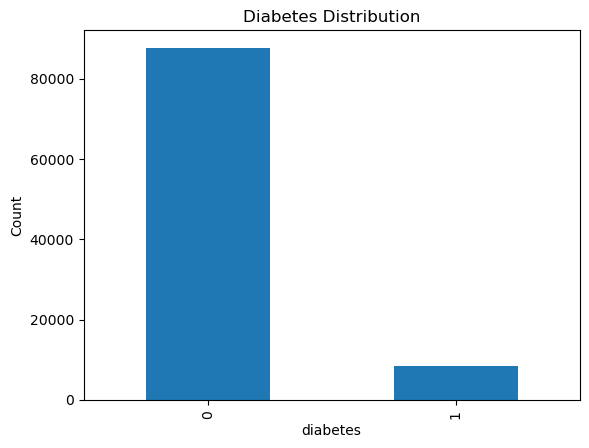

In [12]:
df['diabetes'].value_counts().plot(kind='bar', title='Diabetes Distribution', ylabel='Count')
negative, positive = df['diabetes'].value_counts()
print(f"Negative cases: {negative}, Positive cases: {positive}, Ratio: {positive/negative:.2f}")

### Observation on diabetes 
- Only 10% of dataset is diabetese positive so it is a rare category.

### 2. Gender

<Axes: title={'center': 'Gender Distribution'}, xlabel='gender'>

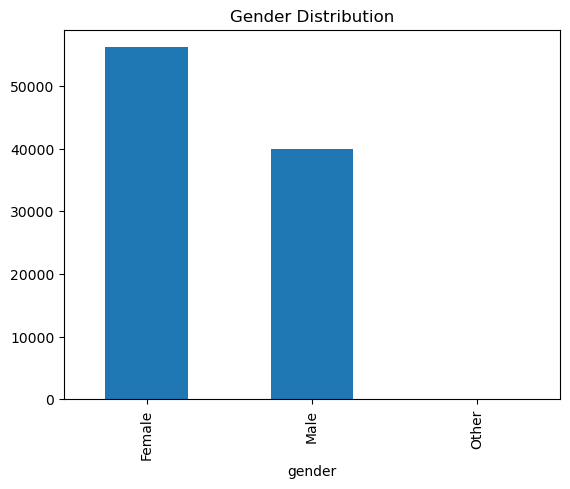

In [13]:
df['gender'].value_counts().plot(kind='bar', title='Gender Distribution')

In [14]:
df['gender'].value_counts()

gender
Female    56161
Male      39967
Other        18
Name: count, dtype: int64

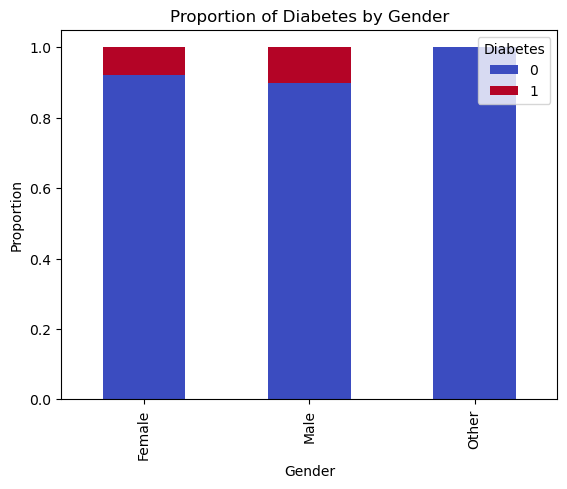

In [15]:
prop_df = df.groupby('gender')['diabetes'].value_counts(normalize=True).unstack()
prop_df.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Proportion of Diabetes by Gender')
plt.ylabel('Proportion')
plt.xlabel('Gender')
plt.legend(title='Diabetes')
plt.show()

### Observations on gender
- gender has 3 values male,female and other
- other has only 18 rows and none of the 18 rows have a diabetes case; so it does not carry a signal that the model can learn from so it is better to remove it. 

- **FEATURE ENGINEERING IS DONE IN FEATURE ENGINEERING SECTION**

### 3. Smoking History

<Figure size 1000x600 with 0 Axes>

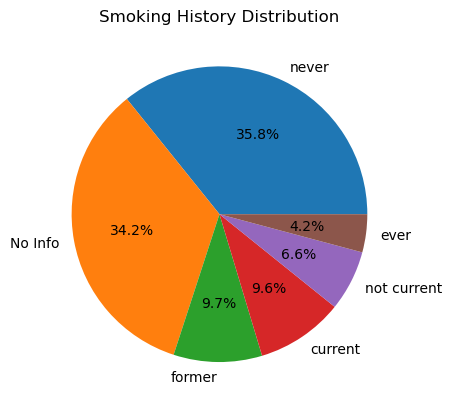

<Figure size 1000x600 with 0 Axes>

In [16]:
df['smoking_history'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Smoking History Distribution', ylabel= '')
plt.figure(figsize=(10, 6))

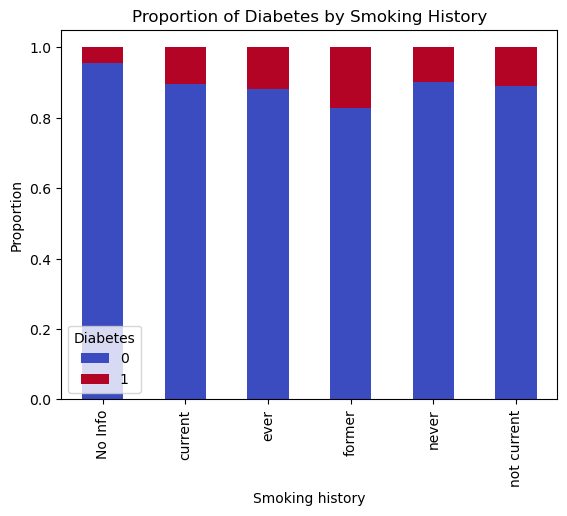

In [17]:
prop_df = df.groupby('smoking_history')['diabetes'].value_counts(normalize=True).unstack()
prop_df.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Proportion of Diabetes by Smoking History')
plt.ylabel('Proportion')
plt.xlabel('Smoking history')
plt.legend(title='Diabetes')
plt.show()


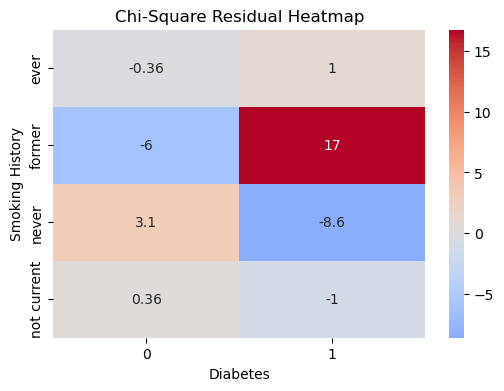

In [18]:
from scipy.stats import chi2_contingency

# -- Observe correlation between smoking history and diabetes for categories that could be merged

# Filter for 4 smoking categories to compare
subset = df[df['smoking_history'].isin(['ever', 'former', 'not current', 'never'])]

# Create contingency table for chi-square test
contingency = pd.crosstab(subset['smoking_history'], subset['diabetes'])

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency)

# Standardized residuals
residuals = (contingency - expected) / expected**0.5

# Plot heatmap of residuals
plt.figure(figsize=(6,4))
sns.heatmap(residuals, annot=True, cmap='coolwarm', center=0)
plt.title('Chi-Square Residual Heatmap')
plt.xlabel('Diabetes')
plt.ylabel('Smoking History')
plt.show()


### Observation for Smoking History

The smoking_history column contains the following values:
- No Info
- Never
- Former
- Current
- Not current
- Ever

#### Why Some Categories Were Grouped

- In the bar chart, both "ever" and "not current" have similar rates of diabetes, which is lower than the rate seen in "former".
- The "former" group has a higher rate of diabetes, which suggests a higher risk.
- From the chi-square results:
  - "former" stands out clearly with a large positive value, meaning more diabetic cases than expected.
  - "ever" and "not current" are close to the expected range, showing no strong effect.
  - "never" has fewer diabetic cases than expected, meaning this group is at lower risk.

#### What This Shows

- The "former" group likely includes individuals who smoked more or for longer periods in the past, which puts them at higher risk — this group is kept as-is and renamed to Former_HighRisk.
- "ever" and "not current" are likely lighter or occasional smokers in the past, so they are grouped together as Former_LowRisk.
- "never" shows a different trend with low risk and is kept as its own category.
- "current" remains its own group since it refers to people who still smoke.
- "No Info" is kept separate due to missing data.

---

### Final Category Mapping for smoking_history

| Original Category | New Category       | Reason                                                  |
|-------------------|--------------------|----------------------------------------------------------|
| Former            | Former_HighRisk    | Higher chance of diabetes based on the data              |
| Ever              | Former_LowRisk     | Similar to "not current", lower diabetes rate            |
| Not current       | Former_LowRisk     | Similar to "ever", lower diabetes rate                   |
| Never             | Never              | Clearly different, with the lowest diabetes rate         |
| Current           | Current            | Still smoking, different from others                     |
| No Info           | NoInfo             | Missing data, kept as its own group                      |


- **FEATURE ENGINEERING IS DONE IN FEATURE ENGINEERING SECTION**

### 4. Hypertension 

<Axes: title={'center': 'Hypertension Distribution'}, xlabel='hypertension'>

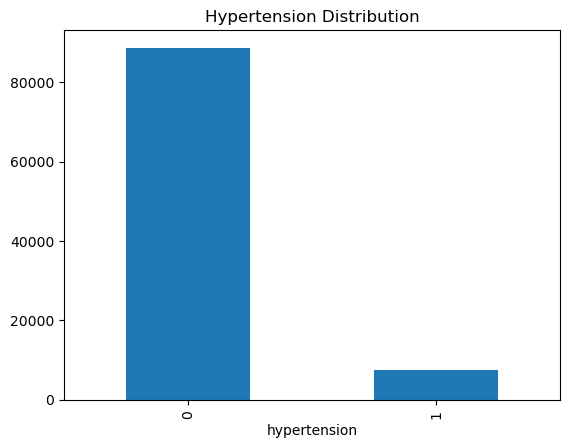

In [19]:
df['hypertension'].value_counts().plot(kind='bar', title='Hypertension Distribution')

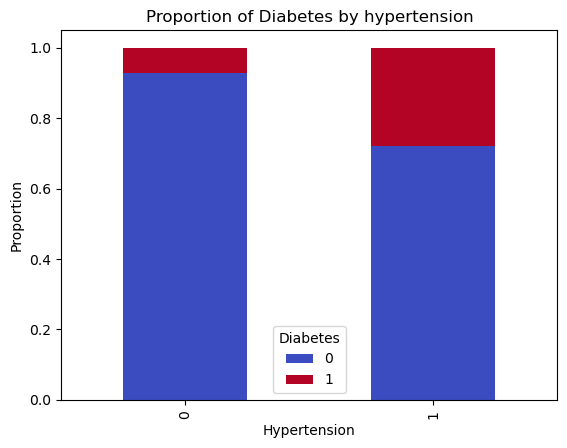

In [20]:
prop_df = df.groupby('hypertension')['diabetes'].value_counts(normalize=True).unstack()
prop_df.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Proportion of Diabetes by hypertension')
plt.ylabel('Proportion')
plt.xlabel('Hypertension')
plt.legend(title='Diabetes')
plt.show()

### Observations on hypertension 
- Distribution of hypertension is not normal as hypertension positive is rare. 
- There is a high correlation of diabetes with hypertension; the proportion of diabetes by hypertension table shows that proportion of diabetes greatly increases with hypertension positive.

### 5. Heart disease

<Axes: title={'center': 'Heart disease Distribution'}, xlabel='heart_disease'>

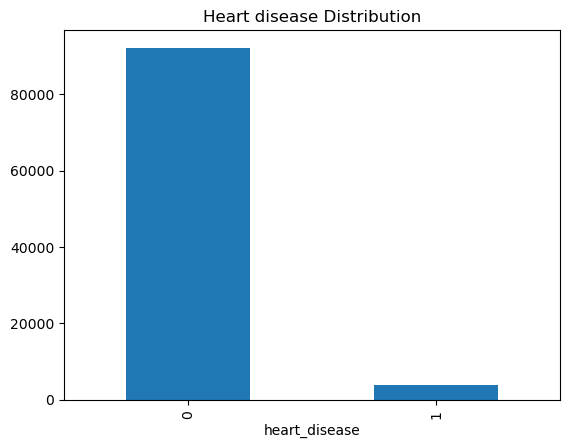

In [21]:
df['heart_disease'].value_counts().plot(kind='bar', title='Heart disease Distribution')

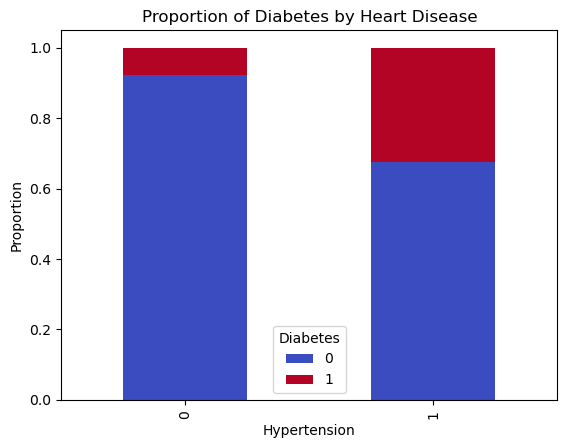

In [22]:
prop_df = df.groupby('heart_disease')['diabetes'].value_counts(normalize=True).unstack()
prop_df.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Proportion of Diabetes by Heart Disease')
plt.ylabel('Proportion')
plt.xlabel('Hypertension')
plt.legend(title='Diabetes')
plt.show()

### Observations on heart disease
- Distribution of heart disease is not normal as heart disease positive is rare. 
- There is a high correlation of diabetes with heart disease; the proportion of diabetes by heart disease table shows that proportion of diabetes greatly increases with heart disease positive.

### 6. Age

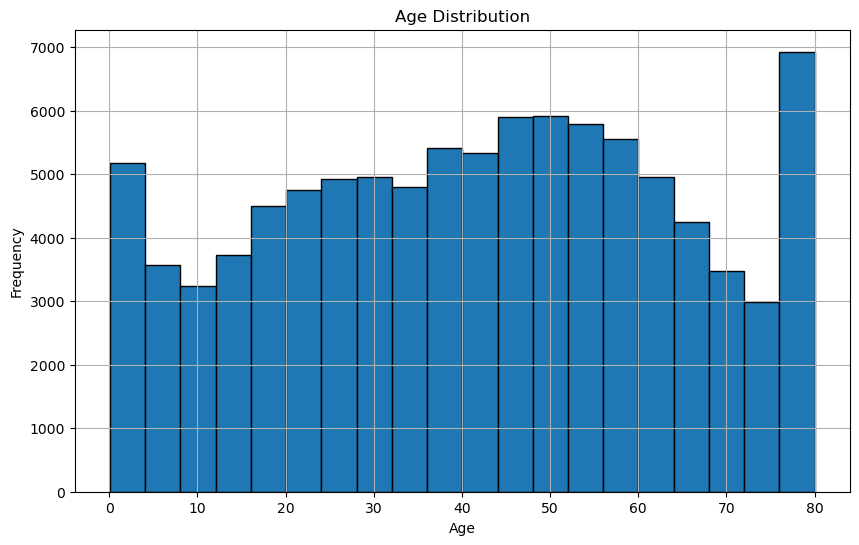

In [23]:
plt.figure(figsize=(10, 6))
df['age'].hist(bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

C:\Users\Palan\AppData\Local\Temp\ipykernel_23036\3358456875.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diabetes_rate = df.groupby(age_bins)['diabetes'].mean()


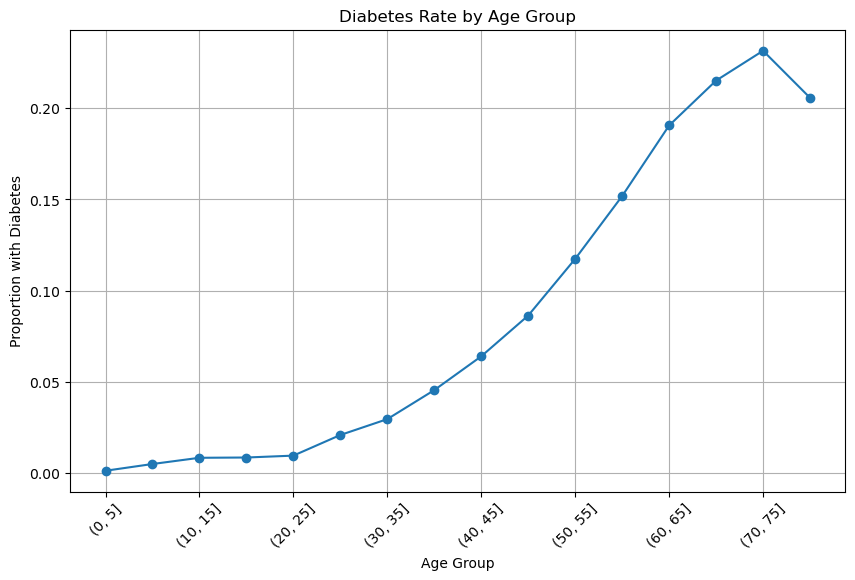

In [24]:
# Bin ages and plot diabetes rate per bin
age_bins = pd.cut(df['age'], bins=np.arange(0, 81, 5))  # 5-year bins
diabetes_rate = df.groupby(age_bins)['diabetes'].mean()

plt.figure(figsize=(10,6))
diabetes_rate.plot(marker='o')
plt.xlabel('Age Group')
plt.ylabel('Proportion with Diabetes')
plt.title('Diabetes Rate by Age Group')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Observations on age
- The distribution of age is mostly uniform with low skew.
- There is high linear correlation of age with diabetes. The number of diabetics greatly increase with age

### 7. BMI

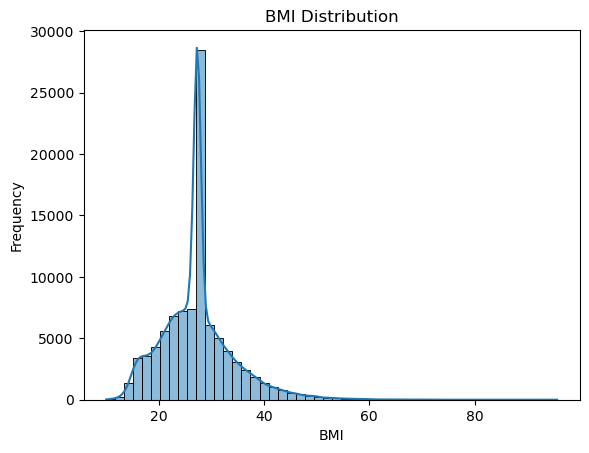

In [25]:
sns.histplot(df['bmi'], bins=50, kde = True, edgecolor='black') #kde = True adds a kernel density estimate
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

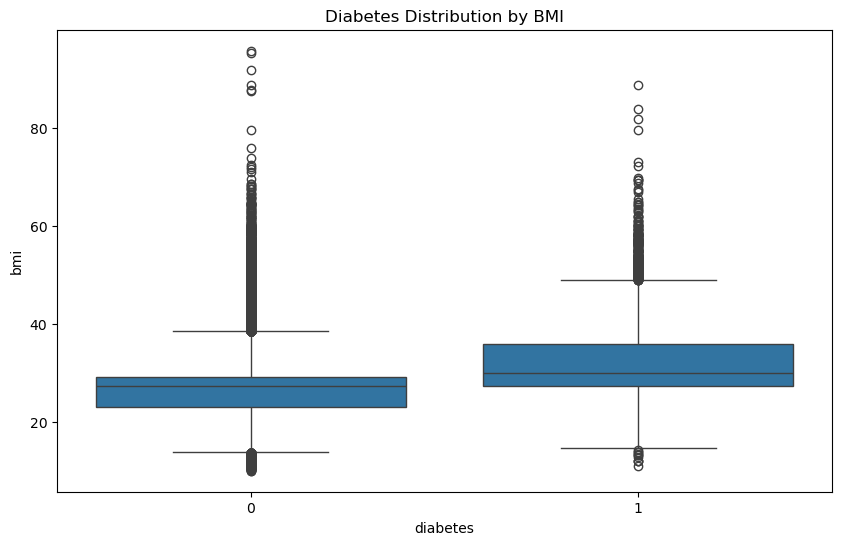

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='diabetes', y='bmi', data=df)
plt.title('Diabetes Distribution by BMI')
plt.show()

### Observation on BMI 
- BMI distribution histogram:
    - BMI distribution is right skewed; most rows have low BMI. 
    - There is a high spike in BMI range 27-30
- In the diabetes distribution by BMI boxplot the median of diabetes positive is higher than that of negative; this means there is a correlation of high BMI with risk of diabetes.
- BMI should not be binned as there is no clear clustering of values in the histogram to show what is underweight and what is obese. 


### 8. HbA1c

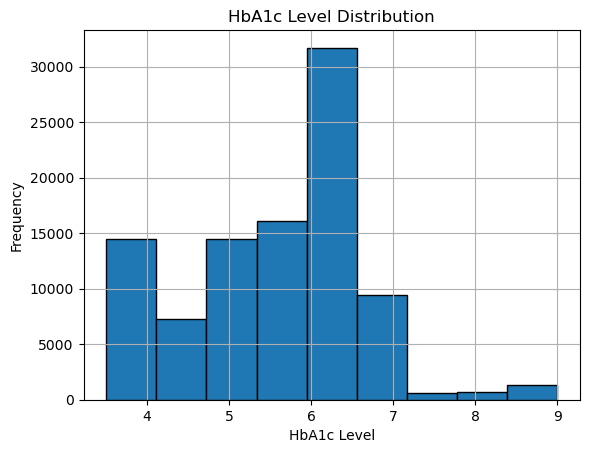

In [27]:
df['HbA1c_level'].hist(bins=9, edgecolor='black')
plt.title('HbA1c Level Distribution')               
plt.xlabel('HbA1c Level')
plt.ylabel('Frequency')
plt.show()

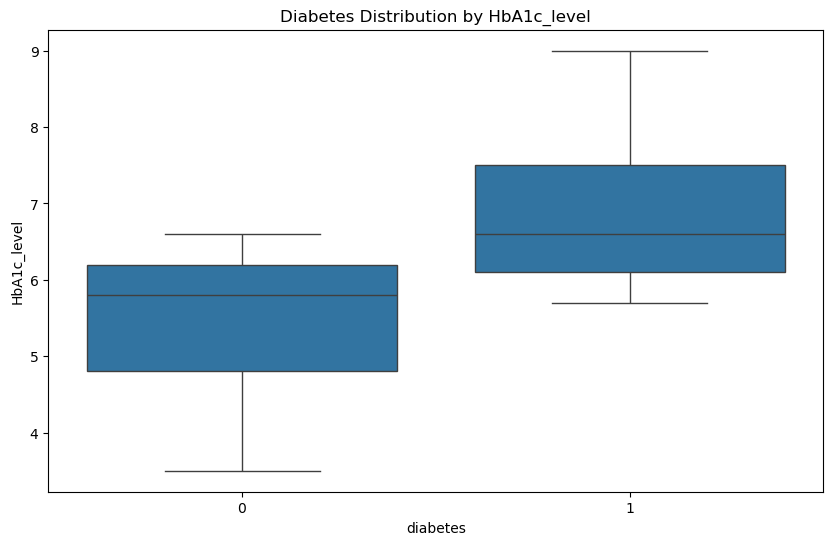

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='diabetes', y='HbA1c_level', data=df)
plt.title('Diabetes Distribution by HbA1c_level')
plt.show()

#### Observations on HbA1c_level
- The distribution of HbA1C_level is not normal and right skewed
- In the Diabetes Distribution by HbA1c_level boxplot; the median of diabetes positive has a much higher median than that of diabetes negative this shows that there is a high correlation between high HbA1c_level and likelihood of diabetes. 

### 9. Blood glucose

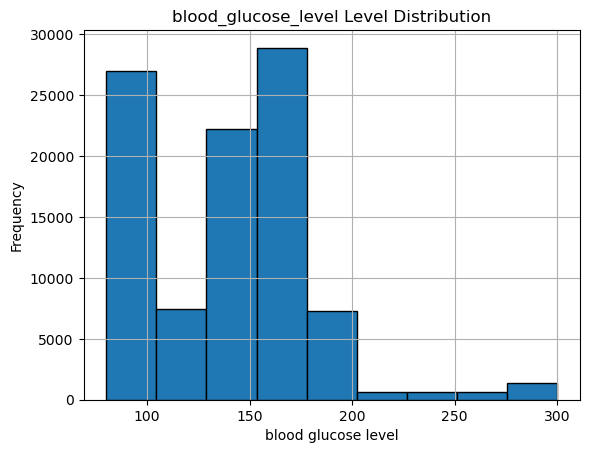

In [29]:
df['blood_glucose_level'].hist(bins=9, edgecolor='black')
plt.title('blood_glucose_level Level Distribution')               
plt.xlabel('blood glucose level')
plt.ylabel('Frequency')
plt.show()

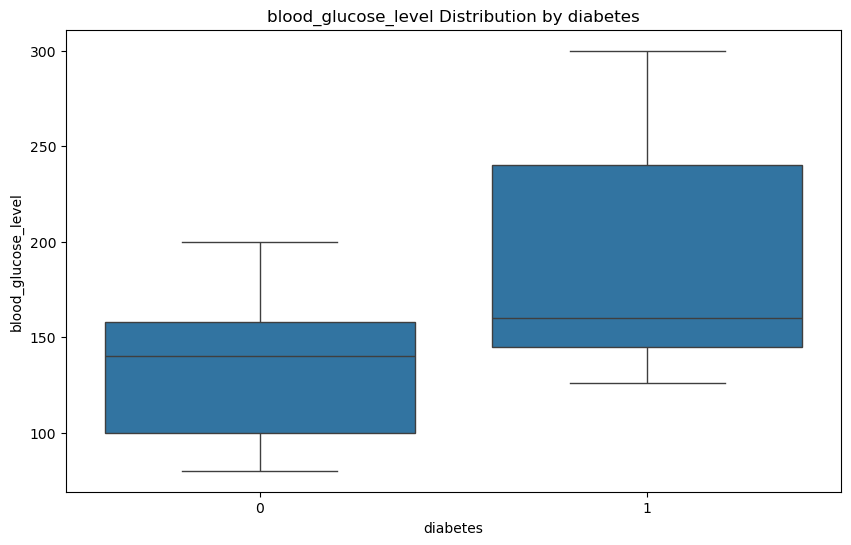

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df)
plt.title('blood_glucose_level Distribution by diabetes')
plt.show() 

#### Observations on blood glucose level
- The distribution of blood glucose level is not normal
- In the Diabetes Distribution by blood glucose level boxplot; the median of diabetes positive has a higher median than that of diabetes negative this shows that there is a  correlation between high HbA1c_level and likelihood of diabetes. 

### Calculate skew of numeric fields
- im not sure if the skew i observed is correct so here is the code to verify

In [31]:
# Calculate skewness for numeric columns
numeric_cols = df.select_dtypes(include='number').columns
skew_values = df[numeric_cols].skew()
print("Skewness of numeric columns:")
print(skew_values)

Skewness of numeric columns:
age                   -0.062445
hypertension           3.157676
heart_disease          4.642359
bmi                    1.023751
HbA1c_level           -0.054463
blood_glucose_level    0.836489
diabetes               2.903845
dtype: float64


#### skew observations
- age: -0.05 
    - very close to 0, nearly symmetric distribution
- hypertension: 3.23 
    - highly right-skewed, most values are 0, few are 1
- heart_disease: 4.73 
    - highly right-skewed, most values are 0, few are 1
- bmi: 1.04 
    - moderately right-skewed, more low BMI values, some high outliers
- HbA1c_level: -0.07 
    - very close to 0, almost symmetric
- blood_glucose_level: 0.82 
    - moderate right skew, more low values, some high outliers
- diabetes: 2.98 
    - highly right-skewed, most people are non-diabetic


Conclusion:
- **Heart disease and hypertension are binary categories they dont need skew handling**
- **Diabetes is the target so skew handling not required**

## Multivariate Analysis

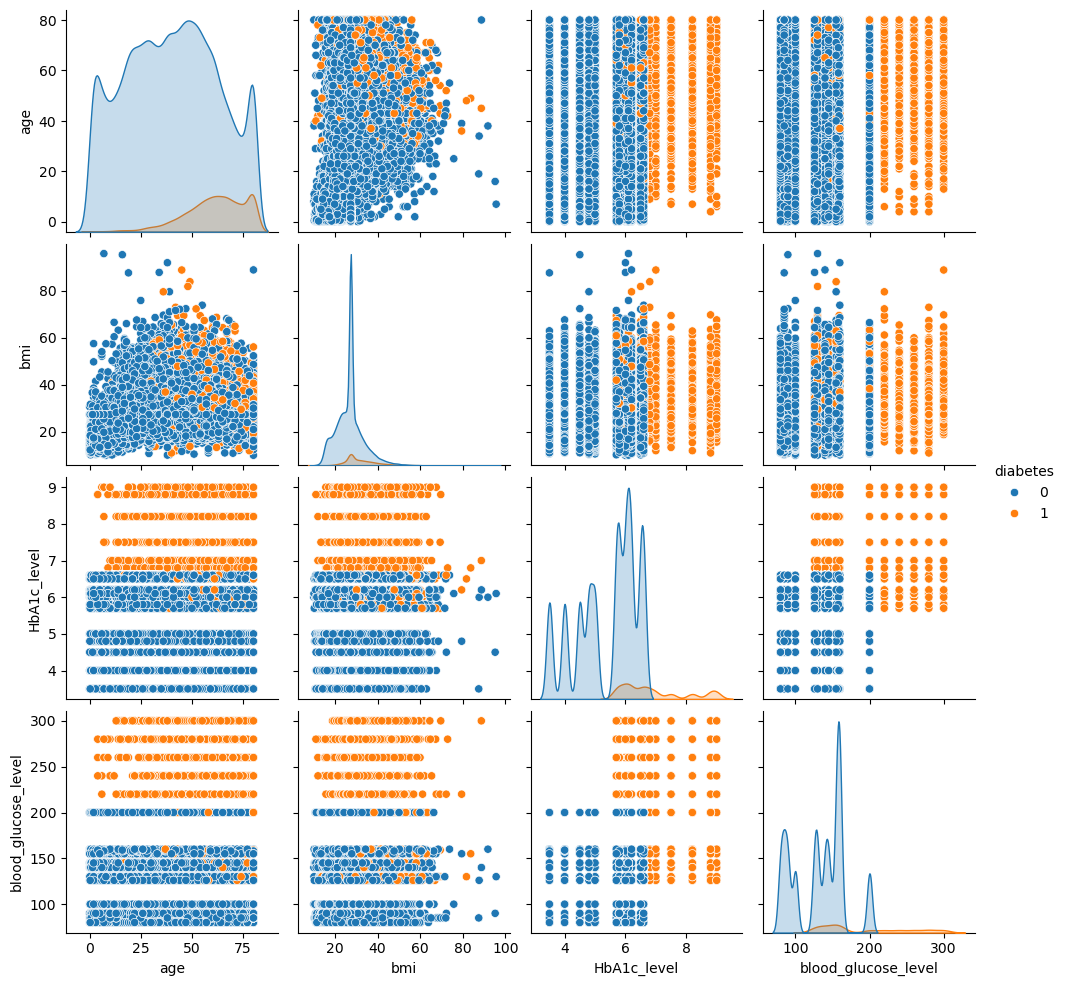

In [32]:
# Pair plot for numeric features
sns.pairplot(df, vars = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'], hue='diabetes')
plt.show()

### observation on correlation between numeric features
- Diabetics are more common in older age groups as the age distribution of diabetics is right skewed
- Both diabetics and non diabetics are most concentrated between 20-40BMI; however there is no clear seperation showing that BMI does not have strong correlation with target. 
- HbA1c_level has strong seperation as more than 6.5 means diabetic while non diabetics are mostly between 4-6.5. High correlation with target.
- Blood glucose level has strong seperation; more than 200 is mostly diabetic whereas less than 200 is mostly non diabetics. High correlation with target
- Older individuals with higher glucose are mostly diabetic (orange).
- High glucose and high HbA1c → diabetic.Low values of both → non-diabetic. There is a positive correlation between HbA1c_level and blood_glucose_level as HbA1c_level tends to increase with blood_glucose_level
- There is no strong correlation between bmi and blood_glucose.
- There is no strong correlation between bmi and HbA1c_level.
- Younger indviduals are less likely to have high HbA1c_level


# Choice of Model

## Observations Based on EDA

The dataset contains approximately 100,000 rows with both numeric and categorical features.  
Variables like `age` show a linear trend with diabetes, while `blood_glucose_level` and `HbA1c_level` have threshold effects — values above 200 and 6.5 respectively are likely diabetic.  
`hypertension` and `heart_disease` also show strong association with diabetes risk.

- The target variable is imbalanced (only ~10% positive class).
- Some features are skewed.
- Some categories are rare.

---

## Factors That Affect Model Choice

- Binary classification task
- Presence of class imbalance
- Both linear and non-linear relationships
- Skewed numerical features (e.g., BMI, blood glucose)
- Rare categorical groups
- Accuracy is not suitable due to imbalance

---

## Exploring Possible Models

### Logistic Regression
- Linear model
- Good for baseline comparison
- Requires scaling and one-hot encoding
- Sensitive to skew and outliers

### LinearSVC (Linear Support Vector Classifier)
- Finds maximum margin boundary
- Effective in high dimensions
- Requires scaling and one-hot encoding
- Slower than Logistic Regression on large data

### Gaussian Naive Bayes
- Assumes feature independence and Gaussian distribution
- Extremely fast, handles large datasets
- Requires numeric inputs and scaling
- Good baseline but weak assumptions

### Decision Tree
- Non-linear splits (e.g., "if blood_glucose > 200")
- Interpretable and good with rare categories
- Requires label encoding
- Risk of overfitting

### Random Forest
- Bagging ensemble of trees
- Reduces overfitting
- Handles imbalance and mixed features
- Requires label encoding

### Gradient Boosting Classifier
- Learns from residuals sequentially
- Excels at non-linear patterns and recall
- Slower, needs tuning
- Requires label encoding

### Hist Gradient Boosting
- Scalable version of boosting
- Supports categorical features directly
- Efficient for large datasets
- Minimal preprocessing needed

### K-Nearest Neighbors
- Lazy learning using distance metrics
- Requires scaling and one-hot encoding
- Not scalable for large datasets
- Added for baseline comparison

---

## Feature Engineering Requirements

| Model                         | Scaling Required | Encoding Required     | Skew Handling Needed | Notes                                             |
|------------------------------|------------------|------------------------|-----------------------|---------------------------------------------------|
| Logistic Regression           | Yes              | One-Hot Encoding       | Yes                   | Linear model; sensitive to skew                   |
| Linear SVC                    | Yes              | One-Hot Encoding       | Yes                   | Margin-based; scaling is essential                |
| Gaussian Naive Bayes          | Yes              | One-Hot Encoding       | Yes                   | Fast; Gaussian assumptions                        |
| Decision Tree                 | No               | Label Encoding         | No                    | Rule-based; overfits without pruning              |
| Random Forest                 | No               | Label Encoding         | No                    | Good balance of bias/variance                     |
| Gradient Boosting             | No               | Label Encoding         | No                    | Strong performance on imbalanced data             |
| Hist Gradient Boosting        | No               | Optional               | No                    | Efficient, handles missing and categorical values |
| K-Nearest Neighbors           | Yes              | One-Hot Encoding       | Yes                   | Distance-based; not scalable                      |

---

## Final Models Selected for Comparison

| Model                         | Reason for Selection |
|------------------------------|----------------------|
| Logistic Regression           | Interpretable, linear baseline |
| Linear SVC                    | Margin-based linear classifier |
| Gaussian Naive Bayes          | Probabilistic, fast baseline   |
| Decision Tree                 | Interpretable, handles thresholds |
| Random Forest                 | Ensemble, handles imbalance well |
| Gradient Boosting             | Captures non-linear, rare cases |
| Hist Gradient Boosting        | Efficient, scalable boosting |
| K-Nearest Neighbors           | Simple baseline; included for contrast |

---

## Hyperparameter Tuning

### Comparison of Methods

| Method             | Strategy         | Pros                                        | Cons                                       | When to Use                      |
|--------------------|------------------|---------------------------------------------|---------------------------------------------|----------------------------------|
| GridSearchCV       | Exhaustive       | Simple, thorough                            | Very slow on large search spaces            | Narrow search space              |
| RandomizedSearchCV | Random sampling  | Faster, broader search                      | Might miss the best params                  | Quick tuning                     |
| Optuna             | Bayesian         | Efficient, fewer trials needed              | Slightly complex setup                      | Recommended for large datasets   |

We selected **Optuna** due to its adaptive search and ability to efficiently optimize complex models.  
Each model was tuned using **5-fold cross-validation** and an early stopping callback after **100 non-improving trials**.


# Choice of Evaluation Metrics for Diabetes Prediction

In predicting diabetes using machine learning, metric selection must account for two key factors:

1. **Class imbalance** – Only \~10% of patients have diabetes.
2. **Medical risk** – Missing a diabetic patient (false negative) is far more serious than a false alarm (false positive).

---

### Threshold-Dependent Metrics

These metrics depend on setting a decision threshold to convert predicted probabilities into class labels. They are especially useful for evaluating how a model performs in actual predictions.

#### 1. Recall = TP / (TP + FN)

Measures how many actual diabetic patients were correctly identified.

* **TP (True Positives):** Correctly predicted diabetic patients
* **FN (False Negatives):** Diabetic patients predicted as non-diabetic
* Most critical metric in this context — missing a diabetic (FN) could be life-threatening.

#### 2. Precision = TP / (TP + FP)

Of all patients predicted as diabetic, how many are actually diabetic?

* **FP (False Positives):** Non-diabetic patients predicted as diabetic
* High FP causes unnecessary stress and tests, so Precision should not be too low.

#### 3. F1 Score = 2 × (Precision × Recall) / (Precision + Recall)

Harmonic mean of Precision and Recall.

* Balances the trade-off between Precision and Recall.
* Suitable for imbalanced datasets where both false negatives and false positives matter.

### 4. Accuracy = (TP + TN) / (TP + TN + FP + FN)

Not reliable here.

* With 90% non-diabetics, predicting everyone as "non-diabetic" gives 90% accuracy — misleading and useless for actual risk detection.

---

### Which Threshold-Dependent Metric to Prioritize?

* **Primary Focus: Recall**
  In healthcare, false negatives are costly. Therefore, Recall is prioritized to catch as many diabetic cases as possible.

* **Caution on Precision**
  Very low Precision leads to too many false positives. While not dangerous, it causes stress and wastes medical resources.

* **Compromise Metric: F1 or F2 Score**

  * F1 balances both metrics.
  * F2 (optional) puts more weight on Recall if it’s deemed more important.

> In deployment, I will include a user disclaimer:
> *"This is a preliminary risk assessment. For any positive prediction, please consult a medical professional for confirmation."*

---

### Threshold-Independent Metrics

These metrics evaluate model performance across all thresholds. They give a global view of ranking ability, not just classification at a fixed cutoff.

#### 1. ROC AUC (Receiver Operating Characteristic – Area Under Curve)

Measures how well the model separates positives from negatives at all thresholds.

* Considers all four outcomes (TP, FP, TN, FN)
* Not ideal for imbalanced data, as the high number of TNs can inflate the score

#### 2. PR AUC (Precision-Recall Area Under Curve)

Plots Precision vs Recall across thresholds.

* Focuses only on the positive (diabetic) class
* More informative than ROC AUC in imbalanced medical datasets

---

### Final Metric Strategy

| Purpose              | Metric Used                 | Justification                                           |
| -------------------- | --------------------------- | ------------------------------------------------------- |
| Model training       | PR AUC                      | Best for imbalanced data; balances Recall and Precision |
| Model selection      | Recall, Precision, F1 Score | Choose models with high Recall and reasonable Precision |
| Secondary evaluation | Confusion Matrix            | Visual breakdown of TP, FP, FN, TN                      |
| Avoid using          | Accuracy, ROC AUC           | Misleading due to class imbalance and TN dominance      |


# Feature engineering

- Removed other categories in gender (refer to EDA, univariate analysis section for justification)
- Merged similar categories in smoking history together
- Seperate feature engineering for tree models and non tree models:
- Accessed whether any feature should be dropped using SHAP after model is selected at the end of the notebook (selected model; histGB does not support feature importance)
    - dropped features seperately and and observed whether there is improvement in metrics

1. Tree models feature engineering
    - split into test and train sets
    - label encoding for category features

2. Non tree model feature engineering
    - split into test and train
    - handle skew in blood glucose level and bmi using log transform
    - scale numeric features using standard scaler ('age', 'bmi', 'HbA1c_level', 'blood_glucose_level')
    - OHE for category features

### 1. Remove other category in gender
- only 18 rows in 100k row dataset
- Dont have any strong correlation to diabetes (EDA pt. 2)

<Axes: title={'center': 'Check Gender Distribution Again'}, xlabel='gender'>

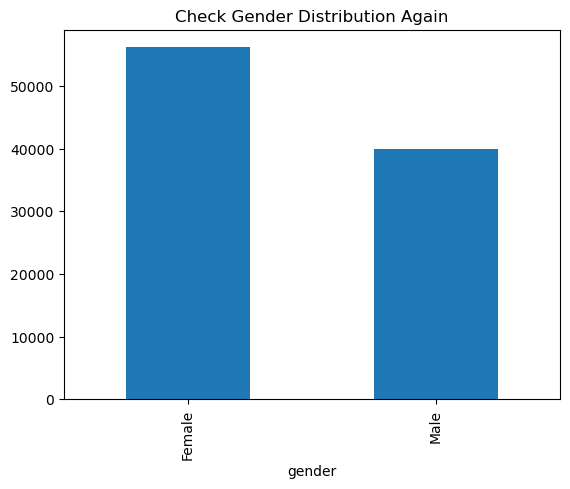

In [33]:
df = df[df['gender']!= 'Other']
df['gender'].value_counts().plot(kind='bar', title='Check Gender Distribution Again')

### 2. Merge similar columns in smoking history
- categories have similar correlation with diabetes and logically former, not current and ever all refer to the same thing.

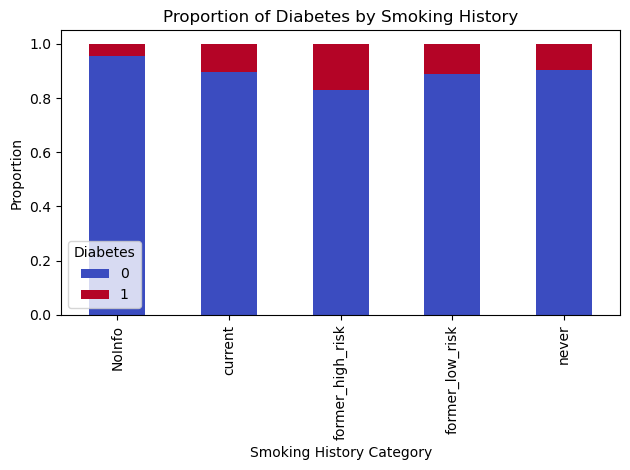

In [34]:
mapping = {
    'former':       'former_high_risk',
    'not current':  'former_low_risk',
    'ever':         'former_low_risk',
    'never':        'never',
    'current':      'current',
    'No Info':      'NoInfo'  # remove the space to avoid key errors later
}

df['smoking_history'] = df['smoking_history'].map(mapping)

# Plot updated proportions
prop_df = df.groupby('smoking_history')['diabetes'].value_counts(normalize=True).unstack()
prop_df.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Proportion of Diabetes by Smoking History')
plt.ylabel('Proportion')
plt.xlabel('Smoking History Category')
plt.legend(title='Diabetes')
plt.tight_layout()
plt.show()

### 3. Tree model data engineering
- require label encoding gender and smoking history
- do not need scaling


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Split first
df_LE = df.copy()
X_LE = df_LE.drop('diabetes', axis=1)
y_LE = df_LE['diabetes']

X_LE_train, X_LE_test, y_LE_train, y_LE_test = train_test_split(
    X_LE, y_LE, test_size=0.2, random_state=42, stratify=y_LE
)

# Fit encoder only on training set to prevent data leakage
le_gender = LabelEncoder()
le_smoking = LabelEncoder()

X_LE_train['gender'] = le_gender.fit_transform(X_LE_train['gender'])
X_LE_train['smoking_history'] = le_smoking.fit_transform(X_LE_train['smoking_history'])

# Transform test set using same mapping
X_LE_test['gender'] = le_gender.transform(X_LE_test['gender'])
X_LE_test['smoking_history'] = le_smoking.transform(X_LE_test['smoking_history'])

##### Other model data engineering
- require OHE gender and smoking history
- do need scaling
- skew has to be handled using log transform for BMI and blood glucose level (based on skewness analysis)

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# 1. Copy original dataframe
df_OHE = df.copy()

# 2. Handle skewness (log-transform for linear models)
df_OHE['bmi'] = np.log1p(df_OHE['bmi'])  
df_OHE['blood_glucose_level'] = np.log1p(df_OHE['blood_glucose_level'])

# 3. One-hot encode categorical variables
df_OHE = pd.get_dummies(df_OHE, columns=['gender', 'smoking_history'])

# 4. Split BEFORE scaling (to prevent leakage)
X_OHE = df_OHE.drop('diabetes', axis=1)
y_OHE = df_OHE['diabetes']

X_OHE_train, X_OHE_test, y_OHE_train, y_OHE_test = train_test_split(
    X_OHE, y_OHE, test_size=0.2, random_state=42, stratify=y_OHE
)

# 5. Scale numeric features ONLY on training data
numerical = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

scaler = StandardScaler()
X_OHE_train[numerical] = scaler.fit_transform(X_OHE_train[numerical])  # fit only on train
X_OHE_test[numerical] = scaler.transform(X_OHE_test[numerical])        # transform test


#### Code to handle stopping model training if no improvement
- I wasnt sure what ntrials to set for each model and i felt like setting a number to stop at is guessing when model will be optimal so i created this function
- It stops model when no improvement in last 100 trials (100 to be very certain model has reached best result)

In [37]:
from math import inf

def early_stop_callback(no_improve_trials):
    # Returns a callback function that stops the study if there is no improvement for `no_improve_trials`.

    best_score = {"value": -inf, "no_improve_count": 0} # -inf so no matter what, the first trial will be better

    def callback(study, trial):
        nonlocal best_score
        if trial.value > best_score["value"]: # Update best score if current trial is better
            best_score["value"] = trial.value # Update the best score
            best_score["no_improve_count"] = 0 # Reset no improvement count
        else:
            best_score["no_improve_count"] += 1  # Increment no improvement count  

        if best_score["no_improve_count"] >= no_improve_trials:
            print(f"Early stopping: No improvement in {no_improve_trials} trials.")
            study.stop()

    return callback


# Hyperparameter tuning

## Hyper parameter tuning for Random forest
| Parameter           | What It Does                                       | Typical Range                                      |
| ------------------- | -------------------------------------------------- | -------------------------------------------------- |
| n_estimators        | Number of trees in the forest                      | 300 to 1000                                        |
| max_depth           | Maximum depth of each tree                         | None, or 5 to 30                                   |
| min_samples_split   | Minimum samples to split a node                    | 2 to 20                                            |
| min_samples_leaf    | Minimum samples required at a leaf node            | 1 to 10                                            |
| max_features        | Number of features to consider when splitting      | auto, sqrt, log2, float (e.g. 0.3–1.0)             |
| bootstrap           | Whether to use bootstrap sampling                  | True or False                                      |
| class_weight        | Handle class imbalance                             | balanced, balanced_subsample, or custom            |
| criterion           | Function to measure the quality of a split         | gini or entropy                                    |



In [38]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    # Example for RandomForestClassifier, adapt for other models as needed

    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced',
        n_jobs=-1
    )
    
    score = cross_val_score(clf, X_LE_train, y_LE_train, cv=5, scoring='average_precision').mean()
    return score

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, callbacks=[early_stop_callback(100)])

print("Best PR-AUC:", study_rf.best_trial.value)
print("Best Params:", study_rf.best_trial.params)

c:\Users\Palan\anaconda3\envs\ai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-31 00:47:40,439] A new study created in memory with name: no-name-11b6901d-7073-4258-87e7-4177864c2ba7
[I 2025-07-31 00:47:50,334] Trial 0 finished with value: 0.8842195953576152 and parameters: {'n_estimators': 407, 'max_depth': 13, 'min_samples_split': 17, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.8842195953576152.
[I 2025-07-31 00:47:56,788] Trial 1 finished with value: 0.8840517133550645 and parameters: {'n_estimators': 257, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.8842195953576152.
[I 2025-07-31 00:48:18,258] Trial 2 finished with value: 0.8829945083159103 and parameters: {'n_estimators': 917, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf

Early stopping: No improvement in 100 trials.
Best PR-AUC: 0.884670675940432
Best Params: {'n_estimators': 778, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 19}


In [108]:
from sklearn.metrics import average_precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

RFmodel = RandomForestClassifier(**study_rf.best_params, random_state=42, class_weight='balanced', n_jobs=-1)
RFmodel.fit(X_LE_train, y_LE_train)
rf_pred = RFmodel.predict(X_LE_test)


print("Final Test PR-AUC:", average_precision_score(y_LE_test, rf_pred))
print("Final Test Recall:", recall_score(y_LE_test, rf_pred))
print("---------------------------- classification report ---------------------------- \n" ,classification_report(y_LE_test, rf_pred))
print("---------------------------- confusion matrix ---------------------------- \n" ,confusion_matrix(y_LE_test, rf_pred))
print("---------------------------- Model fitting test ----------------------------" , "\nTraining data set recall: "  , recall_score(y_LE_train, RFmodel.predict(X_LE_train)), "\nTesting data set recall: ", recall_score(y_LE_test, rf_pred))

Final Test PR-AUC: 0.471019934566637
Final Test Recall: 0.8952941176470588
---------------------------- classification report ---------------------------- 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95     27450
           1       0.52      0.90      0.65      2550

    accuracy                           0.92     30000
   macro avg       0.75      0.91      0.80     30000
weighted avg       0.95      0.92      0.93     30000

---------------------------- confusion matrix ---------------------------- 
 [[25310  2140]
 [  267  2283]]
---------------------------- Model fitting test ---------------------------- 
Training data set recall:  0.9297478991596638 
Testing data set recall:  0.8952941176470588


## Hyper parameter tuning for Gradient Boosting Classifier

| Parameter         | What It Does                                    | Typical Range           |
|-------------------|-------------------------------------------------|-------------------------|
| n_estimators      | Number of boosting stages                       | 100 to 1000             |
| max_depth         | Maximum depth of individual estimators          | 3 to 15                 |
| min_samples_split | Minimum samples to split an internal node       | 2 to 20                 |
| min_samples_leaf  | Minimum samples required at a leaf node         | 1 to 10                 |
| subsample         | Fraction of samples used for fitting trees      | 0.5 to 1.0              |
| max_features      | Number of features to consider when splitting   | sqrt,

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 400, 800)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.15)
    max_depth = trial.suggest_int('max_depth', 5, 7)
    min_samples_split = trial.suggest_int('min_samples_split', 3, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
    subsample = trial.suggest_float('subsample', 0.8, 0.9)
    max_features = trial.suggest_categorical('max_features', ['sqrt', None])
    
    clf = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        max_features=max_features,
    )
    
    score = cross_val_score(clf, X_LE_train, y_LE_train, cv=5, scoring='average_precision', n_jobs=-1).mean()
    return score

study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, callbacks=[early_stop_callback(100)])
print("Best average_precision:", study_gb.best_trial.value)
print("Best Params:", study_gb.best_trial.params)

[I 2025-07-31 17:38:16,587] A new study created in memory with name: no-name-b0ee7c8b-86f5-4aec-9c92-3cad57bfdda9
[I 2025-07-31 17:39:07,120] Trial 0 finished with value: 0.8595956886424346 and parameters: {'n_estimators': 516, 'learning_rate': 0.08566953905504276, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.8188747496857357, 'max_features': None}. Best is trial 0 with value: 0.8595956886424346.
[I 2025-07-31 17:39:27,030] Trial 1 finished with value: 0.8661989407268056 and parameters: {'n_estimators': 659, 'learning_rate': 0.1447447757904789, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.8346858789676677, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8661989407268056.
[I 2025-07-31 17:40:16,009] Trial 2 finished with value: 0.8530097177881268 and parameters: {'n_estimators': 580, 'learning_rate': 0.1319472661306424, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.8696916484722773, 

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix

gb_model = GradientBoostingClassifier({'n_estimators': 499, 'learning_rate': 0.08108684289213029, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.8263504684616676, 'max_features': 'sqrt'})#**study_gb.best_params)
gb_model.fit(X_LE_train, y_LE_train)
gb_pred = gb_model.predict(X_LE_test)


print("Final Test PR-AUC:", average_precision_score(y_LE_test, gb_pred))
print("Final Test Recall:", recall_score(y_LE_test, gb_pred))
print("---------------------------- classification report ---------------------------- \n" ,classification_report(y_LE_test, gb_pred))
print("---------------------------- confusion matrix ---------------------------- \n" ,confusion_matrix(y_LE_test, gb_pred))
print("---------------------------- Model fitting test ----------------------------" , "\nTraining data set recall: "  , recall_score(y_LE_train, gb_model.predict(X_LE_train)), "\nTesting data set recall: ", recall_score(y_LE_test, gb_pred))

ValueError: No trials are completed yet.

## Hyper parameter tuning for Hist Gradient Boosting Classifier
| Parameter           | What It Does                                       | Typical Range                                      |
| ------------------- | -------------------------------------------------- | -------------------------------------------------- |
| max_iter            | Maximum number of iterations (trees)              | 100 to 1000                                       |
| learning_rate       | Learning rate (shrinkage parameter)               | 0.01 to 0.3                                       |
| max_depth           | Maximum depth of each tree                         | 3 to 15                                           |
| min_samples_leaf    | Minimum samples required at a leaf node           | 1 to 50                                           |
| max_leaf_nodes      | Maximum number of leaves in each tree             | 10 to 100                                         |
| l2_regularization   | L2 regularization parameter                        | 0 to 10                                           |    score = cross_val_score(clf, X_LE_train, y_LE_train, cv=3, scoring='recall', n_jobs=-1).mean()

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

def objective_hist_gb(trial):
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)
    l2_regularization = trial.suggest_float('l2_regularization', 0, 10)
    
    clf = HistGradientBoostingClassifier(
        max_iter=max_iter,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        l2_regularization=l2_regularization,
        random_state=42
    )
    
    score = cross_val_score(clf, X_LE_train, y_LE_train, cv=5, scoring='average_precision', n_jobs=-1).mean()
    return score

study_hist_gb = optuna.create_study(direction='maximize')
study_hist_gb.optimize(objective_hist_gb, callbacks=[early_stop_callback(100)])
print("Best average_precision:", study_hist_gb.best_trial.value)
print("Best Params:", study_hist_gb.best_trial.params)

[I 2025-07-31 16:38:18,710] A new study created in memory with name: no-name-99baecd7-a813-45ff-bc07-8b2248cb00fc
[W 2025-07-31 16:38:18,853] Trial 0 failed with parameters: {'max_iter': 122, 'learning_rate': 0.054818440483014694, 'max_depth': 8, 'min_samples_leaf': 24, 'max_leaf_nodes': 37, 'l2_regularization': 5.788028446296018} because of the following error: TypeError("got an unexpected keyword argument 'sample_weight'").
Traceback (most recent call last):
  File "c:\Users\Palan\anaconda3\envs\ai\lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Palan\AppData\Local\Temp\ipykernel_23036\2900079812.py", line 24, in objective_hist_gb
    score = cross_val_score(clf, X_LE_train, y_LE_train, cv=5, sample_weight=sample_weights, scoring='average_precision', n_jobs=-1).mean()
  File "c:\Users\Palan\anaconda3\envs\ai\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*a

TypeError: got an unexpected keyword argument 'sample_weight'

In [ ]:
from sklearn.metrics import recall_score, classification_report, confusion_matrix

hgb_model = HistGradientBoostingClassifier(
    **study_hist_gb.best_params,
    class_weight="balanced",
    random_state=42
)

hgb_model.fit(X_LE_train, y_LE_train)
hgb_pred = hgb_model.predict(X_LE_test)

print("Final Test PR-AUC:", average_precision_score(y_LE_test, hgb_pred))
print("Final Test Recall:", recall_score(y_LE_test, hgb_pred))
print("---------------------------- classification report ----------------------------")
print(classification_report(y_LE_test, hgb_pred))
print("---------------------------- confusion matrix ----------------------------")
print(confusion_matrix(y_LE_test, hgb_pred))
print("---------------------------- Model fitting test ----------------------------" , "\nTraining data set recall: "  , recall_score(y_LE_train, hgb_model.predict(X_LE_train)), "\nTesting data set recall: ", recall_score(y_LE_test, hgb_pred))

Final Test PR-AUC: 0.44975290893335756
Final Test Recall: 0.9192156862745098
---------------------------- classification report ----------------------------
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     27450
           1       0.48      0.92      0.63      2550

    accuracy                           0.91     30000
   macro avg       0.74      0.91      0.79     30000
weighted avg       0.95      0.91      0.92     30000

---------------------------- confusion matrix ----------------------------
[[24929  2521]
 [  206  2344]]
---------------------------- Model fitting test ---------------------------- 
Training data set recall:  0.9277310924369748 
Testing data set recall:  0.9192156862745098


### Hyper parameter tuning for Decision Tree
| Parameter           | What It Does                                       | Typical Range                                      |
| ------------------- | -------------------------------------------------- | -------------------------------------------------- |
| max_depth           | Maximum depth of the tree                          | 3 to 20                                           |
| min_samples_split   | Minimum samples to split an internal node         | 2 to 20                                           |
| min_samples_leaf    | Minimum samples required at a leaf node           | 1 to 20                                           |
| max_features        | Number of features to consider when splitting     | sqrt, log2, auto, None                            |
| criterion           | Function to measure the quality of a split        | gini or entropy                                   |
| min_impurity_decrease | Minimum impurity decrease required to split      | 0.0 to 0.1                                        |
| class_weight        | Handle class imbalance                             | balanced or None                                  |

In [84]:
from sklearn.tree import DecisionTreeClassifier

def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.0, 0.1)
    
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        min_impurity_decrease=min_impurity_decrease,
        class_weight='balanced',
        random_state=42
    )
    
    score = cross_val_score(clf, X_LE_train, y_LE_train, cv=5, scoring='average_precision', n_jobs=-1).mean()
    return score

study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective_dt, callbacks=[early_stop_callback(100)])
print("Best average_precision:", study_dt.best_trial.value)
print("Best Params:", study_dt.best_trial.params)

[I 2025-07-31 04:15:17,700] A new study created in memory with name: no-name-9e662620-8034-4409-b215-15d9a9281db4
[I 2025-07-31 04:15:21,462] Trial 0 finished with value: 0.710702115366037 and parameters: {'max_depth': 16, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'criterion': 'entropy', 'min_impurity_decrease': 0.02650930954977019}. Best is trial 0 with value: 0.710702115366037.
[I 2025-07-31 04:15:23,159] Trial 1 finished with value: 0.085 and parameters: {'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'criterion': 'entropy', 'min_impurity_decrease': 0.0819756521840183}. Best is trial 0 with value: 0.710702115366037.
[I 2025-07-31 04:15:24,902] Trial 2 finished with value: 0.7132120374985386 and parameters: {'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': None, 'criterion': 'entropy', 'min_impurity_decrease': 0.07781631033712691}. Best is trial 2 with value: 0.7132120374985386.
[I 

Early stopping: No improvement in 100 trials.
Best average_precision: 0.8663189711996948
Best Params: {'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': None, 'criterion': 'entropy', 'min_impurity_decrease': 0.00017459209980380508}


In [113]:
DTmodel = DecisionTreeClassifier(**study_dt.best_params, random_state=42, class_weight='balanced')
DTmodel.fit(X_LE_train, y_LE_train)
DT_pred = DTmodel.predict(X_LE_test)

print("Final Test PR-AUC:", average_precision_score(y_LE_test, DT_pred))
print("Final Test Recall:", recall_score(y_LE_test, DT_pred))
print("---------------------------- classification report ---------------------------- \n" ,classification_report(y_LE_test, DT_pred))
print("---------------------------- confusion matrix ---------------------------- \n" ,confusion_matrix(y_LE_test, DT_pred))
print("---------------------------- Model fitting test ----------------------------" , "\nTraining data set recall: "  , recall_score(y_LE_train, DTmodel.predict(X_LE_train)), "\nTesting data set recall: ", recall_score(y_LE_test, DT_pred))

Final Test PR-AUC: 0.4319317343173432
Final Test Recall: 0.9
---------------------------- classification report ---------------------------- 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27450
           1       0.47      0.90      0.62      2550

    accuracy                           0.91     30000
   macro avg       0.73      0.90      0.78     30000
weighted avg       0.95      0.91      0.92     30000

---------------------------- confusion matrix ---------------------------- 
 [[24867  2583]
 [  255  2295]]
---------------------------- Model fitting test ---------------------------- 
Training data set recall:  0.9210084033613445 
Testing data set recall:  0.9


## Hyper parameter tuning for KNN
| Parameter           | What It Does                                       | Typical Range                                      |
| ------------------- | -------------------------------------------------- | -------------------------------------------------- |
| n_neighbors         | Number of neighbors to consider                    | 10 to 25 *i ncreased to reduce overfit                                           |
| weights             | Weight function for predictions                    | distance                                 |
| algorithm           | Algorithm used to compute nearest neighbors       | auto, ball_tree, kd_tree, brute                   |
| leaf_size           | Leaf size for tree algorithms                      | 10 to 50                                          |
| p                   | Power parameter for Minkowski distance            | 1 (manhattan) or 2 (euclidean)                   |
| metric              | Distance metric to use                             | minkowski, euclidean, manhattan, chebyshev       |

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, classification_report, confusion_matrix
import optuna

def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 10, 25)
    weights = trial.suggest_categorical('weights', ['distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 10, 50)
    p = trial.suggest_int('p', 1, 2)  # 1 = Manhattan, 2 = Euclidean
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])

    clf = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p,
        metric=metric
    )

    score = cross_val_score(clf, X_OHE_train, y_OHE_train, cv=5, scoring='average_precision', n_jobs=-1).mean()
    return score

study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn,  callbacks=[early_stop_callback(100)]) 

print("Best average_precision:", study_knn.best_trial.value)
print("Best Params:", study_knn.best_trial.params)


[I 2025-07-31 04:22:25,514] A new study created in memory with name: no-name-8ea2fe56-2438-4a89-8f40-c911576deb13
[I 2025-07-31 04:23:00,522] Trial 0 finished with value: 0.8068786000708646 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 29, 'p': 1, 'metric': 'euclidean'}. Best is trial 0 with value: 0.8068786000708646.
[I 2025-07-31 04:23:08,517] Trial 1 finished with value: 0.8080554609757258 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 26, 'p': 2, 'metric': 'minkowski'}. Best is trial 1 with value: 0.8080554609757258.
[I 2025-07-31 04:23:26,007] Trial 2 finished with value: 0.8008303565459739 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 40, 'p': 1, 'metric': 'minkowski'}. Best is trial 1 with value: 0.8080554609757258.
[I 2025-07-31 04:23:33,734] Trial 3 finished with value: 0.7884648351555356 and parameters: {'n_neighbors': 10, 'weights'

Early stopping: No improvement in 100 trials.
Best average_precision: 0.8087200275990464
Best Params: {'n_neighbors': 25, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 46, 'p': 2, 'metric': 'euclidean'}


In [115]:
knn_model = KNeighborsClassifier(**study_knn.best_params)
knn_model.fit(X_OHE_train, y_OHE_train)
knn_pred = knn_model.predict(X_OHE_test)

print("Final Test PR-AUC:", average_precision_score(y_OHE_test, knn_pred))
print("Final Test Recall:", recall_score(y_OHE_test, knn_pred))
print("---------------------------- classification report ----------------------------")
print(classification_report(y_OHE_test, knn_pred))
print("---------------------------- confusion matrix ----------------------------")
print(confusion_matrix(y_OHE_test, knn_pred))
print("---------------------------- Model fitting test ----------------------------" , "\nTraining data set recall: "  , recall_score(y_OHE_train, knn_model.predict(X_OHE_train)), "\nTesting data set recall: ", recall_score(y_OHE_test, knn_pred))

Final Test PR-AUC: 0.5802995154383593
Final Test Recall: 0.5782352941176471
---------------------------- classification report ----------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18300
           1       0.94      0.58      0.72      1700

    accuracy                           0.96     20000
   macro avg       0.95      0.79      0.85     20000
weighted avg       0.96      0.96      0.96     20000

---------------------------- confusion matrix ----------------------------
[[18239    61]
 [  717   983]]
---------------------------- Model fitting test ---------------------------- 
Training data set recall:  0.9911764705882353 
Testing data set recall:  0.5782352941176471


## Hyperparameter Tuning for LinearSVC

| Parameter      | What It Does                                           | Typical Range / Options                         |
|----------------|--------------------------------------------------------|--------------------------------------------------|
| C            | Regularization strength (lower = stronger penalty)     | 0.0001 to 10 (log scale)                     |
| loss         | Loss function used for optimization                    | hinge, squared_hinge                        |
| tol          | Tolerance for stopping criteria                        | 1e-6 to 1e-3 (log scale)                     |
| dual         | Solve dual or primal optimization problem              | True if hinge, False if squared_hinge    |
| class_weight | Adjusts weights inversely to class frequencies         | balanced (used for imbalanced dataset)       |
| penalty      | Regularization type (only l2 is allowed)           | l2 (fixed)                                   |
| max_iter    | Maximum number of iterations                           | 10000(fixed)                                  |


In [117]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import optuna

def objective_svm(trial):
    C = trial.suggest_float("C", 0.0001, 10.0, log=True)  # Regularization strength
    loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])  # Loss function
    tol = trial.suggest_float("tol", 1e-6, 1e-3, log=True)  # Tolerance for convergence

    clf = LinearSVC(
        C=C,
        loss=loss,
        penalty='l2',  # Only 'l2' is supported
        class_weight='balanced',
        max_iter=10000,
        tol=tol,
        dual=False if loss == "squared_hinge" else True
    )

    score = cross_val_score(clf, X_OHE_train, y_OHE_train, cv=5, scoring='average_precision', n_jobs=-1).mean()
    return score

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, callbacks=[early_stop_callback(100)])

print("Best average_precision:", study_svm.best_trial.value)
print("Best Params:", study_svm.best_trial.params)

[I 2025-07-31 10:56:35,966] A new study created in memory with name: no-name-15f5d668-dc1f-42e3-870b-0c7250e1cbcd


[I 2025-07-31 10:56:41,703] Trial 0 finished with value: 0.8090754272037198 and parameters: {'C': 0.0003455766773754212, 'loss': 'squared_hinge', 'tol': 6.895860541750869e-05}. Best is trial 0 with value: 0.8090754272037198.
[I 2025-07-31 10:56:45,517] Trial 1 finished with value: 0.806942474837857 and parameters: {'C': 3.846304847167602, 'loss': 'hinge', 'tol': 0.00012882943064389122}. Best is trial 0 with value: 0.8090754272037198.
[I 2025-07-31 10:56:47,776] Trial 2 finished with value: 0.8058654145964701 and parameters: {'C': 0.0005349898105539009, 'loss': 'hinge', 'tol': 2.7499987674811002e-05}. Best is trial 0 with value: 0.8090754272037198.
[I 2025-07-31 10:56:49,649] Trial 3 finished with value: 0.8069488128603222 and parameters: {'C': 0.03852162603327464, 'loss': 'hinge', 'tol': 4.548403112706698e-05}. Best is trial 0 with value: 0.8090754272037198.
[I 2025-07-31 10:56:51,574] Trial 4 finished with value: 0.8069247026510796 and parameters: {'C': 2.3595643299086677, 'loss': 'hi

Early stopping: No improvement in 100 trials.
Best average_precision: 0.8094872266612096
Best Params: {'C': 0.0023738960826875377, 'loss': 'squared_hinge', 'tol': 0.00013816611660831226}


In [123]:
from sklearn.metrics import recall_score, classification_report, confusion_matrix

# Retrieve best hyperparameters
best_params = study_svm.best_trial.params

# Reconstruct model with full parameter set
best_svm = LinearSVC(
    C=best_params['C'],
    loss=best_params['loss'],
    penalty='l2',
    class_weight='balanced',
    max_iter=10000,
    dual=False if best_params['loss'] == 'squared_hinge' else True,
    random_state=42
)

# Train the model
best_svm.fit(X_OHE_train, y_OHE_train)

# --- Predict and Evaluate ---
svm_pred = best_svm.predict(X_OHE_test)

print("Final Test PR-AUC:", average_precision_score(y_OHE_test, svm_pred))
print("Test Recall:", recall_score(y_OHE_test, svm_pred))
print("\n-------- Classification Report --------")
print(classification_report(y_OHE_test, svm_pred))
print("-------- Confusion Matrix --------")
print(confusion_matrix(y_OHE_test, svm_pred))
print("-------- Train vs Test Recall --------")
print("Train Recall:", recall_score(y_OHE_train, best_svm.predict(X_OHE_train)))
print("Test Recall:", recall_score(y_OHE_test, svm_pred))

Final Test PR-AUC: 0.3856330096466109
Test Recall: 0.9035294117647059

-------- Classification Report --------
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     18300
           1       0.42      0.90      0.57      1700

    accuracy                           0.88     20000
   macro avg       0.70      0.89      0.75     20000
weighted avg       0.94      0.88      0.90     20000

-------- Confusion Matrix --------
[[16159  2141]
 [  164  1536]]
-------- Train vs Test Recall --------
Train Recall: 0.89
Test Recall: 0.9035294117647059


## Hyper parameter tuning for Logistic Regression
| Parameter           | What It Does                                       | Typical Range                                      |
| ------------------- | -------------------------------------------------- | -------------------------------------------------- |
| C                   | Inverse of regularization strength                 | 0.01 to 100                                       |
| penalty             | Regularization norm                                | l1, l2, elasticnet, None                          |
| solver              | Optimization algorithm                             | lbfgs, liblinear, saga, newton-cg, sag            |
| max_iter            | Maximum number of iterations                       | 100 to 1000                                       |
| l1_ratio            | Elasticnet mixing parameter (elasticnet only)     | 0.0 to 1.0                                        |
| class_weight        | Handle class imbalance                             | balanced or None                                  |
| fit_intercept       | Whether to calculate intercept                     | True or False                                     |

In [48]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, classification_report, confusion_matrix

# ===================== OPTUNA OBJECTIVE FUNCTION =====================
def objective_lr(trial):
    C = trial.suggest_float('C', 0.01, 100, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'newton-cg', 'sag'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else None
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])

    # ----- Compatibility Fixes -----
    if penalty == 'l1' and solver not in ['liblinear', 'saga']:
        solver = 'liblinear'
    elif penalty == 'elasticnet' and solver != 'saga':
        solver = 'saga'
    elif penalty is None and solver == 'liblinear':
        solver = 'lbfgs'
    elif penalty not in ['l2', None] and solver not in ['saga', 'liblinear']:
        penalty = 'l2'

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
        class_weight='balanced',
        fit_intercept=fit_intercept,
        random_state=42
    )

    score = cross_val_score(model, X_OHE, y_OHE, cv=5, scoring='average_precision', n_jobs=-1).mean()
    return score

# ===================== RUN OPTUNA STUDY =====================
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, callbacks=[early_stop_callback(100)])

print("Best average_precision:", study_lr.best_trial.value)
print("Best hyperparameters:", study_lr.best_trial.params)

# ===================== FIX PARAMETERS FOR FINAL MODEL =====================
params = study_lr.best_trial.params.copy()

# Compatibility fix (again, for safety)
if params['penalty'] == 'l1' and params['solver'] not in ['liblinear', 'saga']:
    params['solver'] = 'liblinear'
elif params['penalty'] == 'elasticnet' and params['solver'] != 'saga':
    params['solver'] = 'saga'
elif params['penalty'] is None and params['solver'] == 'liblinear':
    params['solver'] = 'lbfgs'
elif params['penalty'] not in ['l2', None] and params['solver'] not in ['saga', 'liblinear']:
    params['penalty'] = 'l2'

if params['penalty'] != 'elasticnet':
    params.pop('l1_ratio', None)

[I 2025-07-31 03:06:57,663] A new study created in memory with name: no-name-5c2642a6-30de-4abb-9c86-91984a3a77ec
[I 2025-07-31 03:07:18,340] Trial 0 finished with value: 0.8015667142883119 and parameters: {'C': 2.464619544988171, 'penalty': 'elasticnet', 'solver': 'liblinear', 'max_iter': 499, 'l1_ratio': 0.1627948126469767, 'fit_intercept': False}. Best is trial 0 with value: 0.8015667142883119.
[I 2025-07-31 03:07:31,131] Trial 1 finished with value: 0.7867586749488675 and parameters: {'C': 0.2615357446524048, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 307, 'fit_intercept': False}. Best is trial 0 with value: 0.8015667142883119.
[I 2025-07-31 03:07:56,332] Trial 2 finished with value: 0.8123789769540496 and parameters: {'C': 0.04739451158245582, 'penalty': 'l1', 'solver': 'newton-cg', 'max_iter': 117, 'fit_intercept': True}. Best is trial 2 with value: 0.8123789769540496.
[I 2025-07-31 03:07:57,276] Trial 3 finished with value: 0.813115249586365 and parameters: {'C': 13.64444781

Early stopping: No improvement in 100 trials.
Best average_precision: 0.8132930044960107
Best hyperparameters: {'C': 22.54546809387161, 'penalty': None, 'solver': 'lbfgs', 'max_iter': 912, 'fit_intercept': True}


In [124]:
lr_model = LogisticRegression(**params, class_weight='balanced', random_state=42)
lr_model.fit(X_OHE_train, y_OHE_train)
lr_pred = lr_model.predict(X_OHE_test)

# Evaluation
print("Final Test PR-AUC:", average_precision_score(y_OHE_test, lr_pred))
print("Final Test Recall:", recall_score(y_OHE_test, lr_pred))
print("---------------------------- classification report ----------------------------\n", classification_report(y_OHE_test, lr_pred))
print("---------------------------- confusion matrix ----------------------------\n", confusion_matrix(y_OHE_test, lr_pred))
print("---------------------------- Model fitting test ----------------------------")
print("Training data recall:", recall_score(y_OHE_train, lr_model.predict(X_OHE_train)))
print("Testing data recall:", recall_score(y_OHE_test, lr_pred))


c:\Users\Palan\anaconda3\envs\ai\lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Final Test PR-AUC: 0.38450505123860246
Final Test Recall: 0.8976470588235295
---------------------------- classification report ----------------------------
               precision    recall  f1-score   support

           0       0.99      0.88      0.93     18300
           1       0.42      0.90      0.57      1700

    accuracy                           0.89     20000
   macro avg       0.70      0.89      0.75     20000
weighted avg       0.94      0.89      0.90     20000

---------------------------- confusion matrix ----------------------------
 [[16181  2119]
 [  174  1526]]
---------------------------- Model fitting test ----------------------------
Training data recall: 0.8860294117647058
Testing data recall: 0.8976470588235295


## Hyper parameter tuning for Gaussian Naive Bayes

| Parameter       | What It Does                                                                   | Typical Range             |
| --------------- | ------------------------------------------------------------------------------ | ------------------------- |
| var_smoothing| Adds small value to variance to prevent division by zero and improve stability | 1e-12 to 1e-6 (log scale) |

- The model has very limited parameters

In [73]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import optuna

def objective_gnb(trial):
    # Tune var_smoothing parameter (stability added to variance)
    var_smoothing = trial.suggest_float("var_smoothing", 1e-12, 1e-6, log=True)
    
    clf = GaussianNB(var_smoothing=var_smoothing)
    
    score = cross_val_score(clf, X_OHE_train, y_OHE_train, cv=5, scoring='average_precision', n_jobs=-1).mean()
    return score

study_gnb = optuna.create_study(direction='maximize')
study_gnb.optimize(objective_gnb, callbacks=[early_stop_callback(100)])

print("Best average_precision:", study_gnb.best_trial.value)
print("Best Params:", study_gnb.best_trial.params)


[I 2025-07-31 03:38:59,442] A new study created in memory with name: no-name-d3aba45d-395b-477b-b965-1826867a693f
[I 2025-07-31 03:38:59,822] Trial 0 finished with value: 0.4363088007098705 and parameters: {'var_smoothing': 7.653559052647697e-12}. Best is trial 0 with value: 0.4363088007098705.
[I 2025-07-31 03:39:00,104] Trial 1 finished with value: 0.43631190870159653 and parameters: {'var_smoothing': 1.9018628599682365e-09}. Best is trial 1 with value: 0.43631190870159653.
[I 2025-07-31 03:39:00,398] Trial 2 finished with value: 0.436310375932034 and parameters: {'var_smoothing': 5.88115116808981e-12}. Best is trial 1 with value: 0.43631190870159653.
[I 2025-07-31 03:39:00,693] Trial 3 finished with value: 0.4363163827134235 and parameters: {'var_smoothing': 2.4761111708821713e-09}. Best is trial 3 with value: 0.4363163827134235.
[I 2025-07-31 03:39:01,001] Trial 4 finished with value: 0.4363103945518222 and parameters: {'var_smoothing': 6.591508041697261e-12}. Best is trial 3 with 

Early stopping: No improvement in 100 trials.
Best average_precision: 0.4363298793103928
Best Params: {'var_smoothing': 5.244987746637803e-12}


In [125]:
# Train GaussianNB with best params
best_params = study_gnb.best_trial.params
gnb_model = GaussianNB(**best_params)
gnb_model.fit(X_OHE_train, y_OHE_train)

# Predict
gnb_pred = gnb_model.predict(X_OHE_test)

# Evaluation
print("Final Test PR-AUC:", average_precision_score(y_OHE_test, gnb_pred))
print("Final Test Recall:", recall_score(y_OHE_test, gnb_pred))
print("---------------------------- classification report ----------------------------\n", classification_report(y_OHE_test, gnb_pred))
print("---------------------------- confusion matrix ----------------------------\n", confusion_matrix(y_OHE_test, gnb_pred))
print("---------------------------- Model fitting test ----------------------------")
print("Training data recall:", recall_score(y_OHE_train, gnb_model.predict(X_OHE_train)))
print("Testing data recall:", recall_score(y_OHE_test, gnb_pred))


Final Test PR-AUC: 0.12467803892605786
Final Test Recall: 0.9947058823529412
---------------------------- classification report ----------------------------
               precision    recall  f1-score   support

           0       1.00      0.35      0.52     18300
           1       0.12      0.99      0.22      1700

    accuracy                           0.41     20000
   macro avg       0.56      0.67      0.37     20000
weighted avg       0.92      0.41      0.50     20000

---------------------------- confusion matrix ----------------------------
 [[ 6451 11849]
 [    9  1691]]
---------------------------- Model fitting test ----------------------------
Training data recall: 0.9952941176470588
Testing data recall: 0.9947058823529412


# Final Model Evaluation

Table below shows ouput metrics of each trained model.

| **Model**                       | **Test Recall (Class 1)** | **Precision (Class 1)** | **F1-Score (Class 1)** | **Accuracy** | **Training Recall** | **Confusion Matrix (TP / FN)** |
| ------------------------------- | ------------------------- | ----------------------- | ---------------------- | ------------ | ------------------- | ------------------------------ |
| **HistGradientBoosting (HGBC)** | 0.920                     | 0.47                    | 0.62                   | 0.90         | 0.932               | TP: 1560 / FN: 136             |
| **Decision Tree**               | 0.906                     | 0.44                    | 0.59                   | 0.89         | 0.940               | TP: 1537 / FN: 159             |
| **Random Forest**               | 0.889                     | 0.50                    | 0.64                   | 0.91         | 0.932               | TP: 1507 / FN: 189             |
| **Logistic Regression**         | 0.885                     | 0.42                    | 0.57                   | 0.88         | 0.888               | TP: 1501 / FN: 195             |
| **Linear SVC**                  | 0.904                     | 0.42                    | 0.57                   | 0.88         | 0.890               | TP: 1536 / FN: 164             |
| **Gaussian Naive Bayes**        | **0.995**                 | 0.12                    | 0.22                   | 0.41         | **0.995**           | TP: 1691 / FN: 9               |
| **Gradient Boosting (GBC)**     | 0.698                     | **0.97**                | **0.81**               | **0.97**     | 0.710               | TP: 1183 / FN: 513             |
| **KNN**                         | 0.584                     | **0.93**                | 0.72                   | 0.96         | 0.992               | TP: 991 / FN: 705              |


### 1. Classification report comparison between models

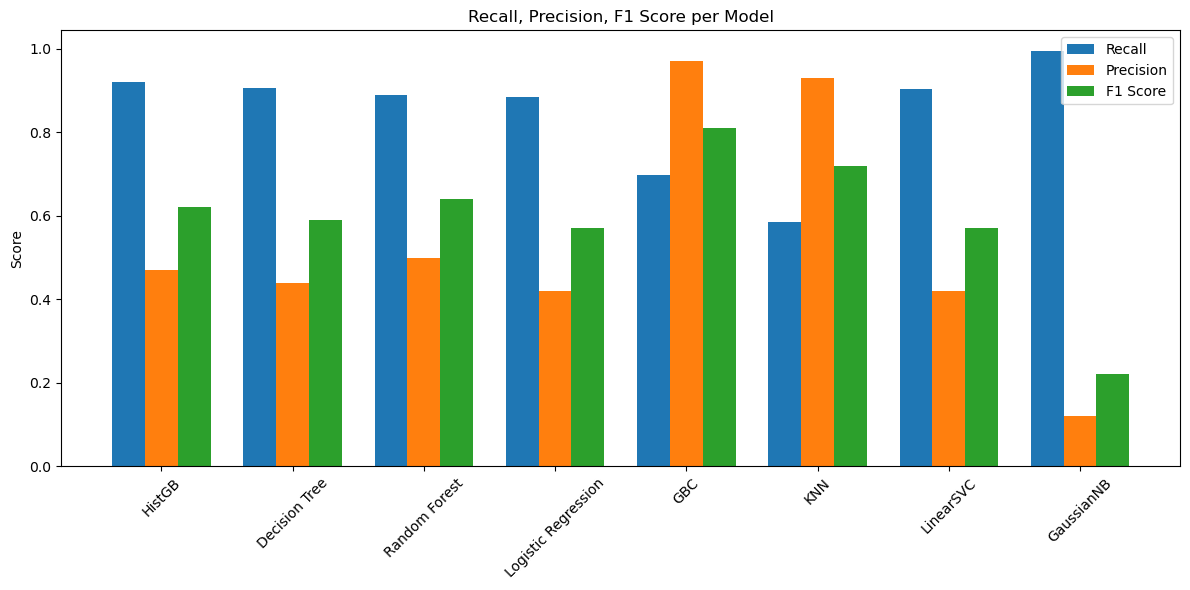

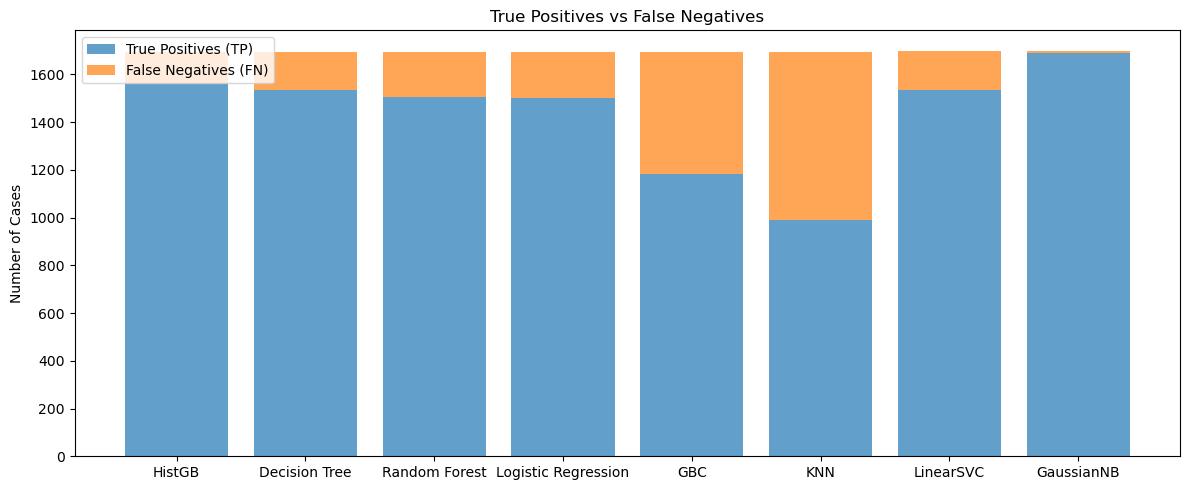

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Model Performance Data (Updated)
model_names = [
    "HistGB", "Decision Tree", "Random Forest",
    "Logistic Regression", "GBC", "KNN",
    "LinearSVC", "GaussianNB"
]

recall = [0.9198, 0.9063, 0.8886, 0.8850, 0.6975, 0.5843, 0.9035, 0.9947]
precision = [0.47, 0.44, 0.50, 0.42, 0.97, 0.93, 0.42, 0.12]
f1 = [0.62, 0.59, 0.64, 0.57, 0.81, 0.72, 0.57, 0.22]
accuracy = [0.90, 0.89, 0.91, 0.88, 0.97, 0.96, 0.88, 0.41]
train_recall = [0.9321, 0.9400, 0.9318, 0.8883, 0.7100, 0.9917, 0.89, 0.9953]
fn = [136, 159, 189, 195, 513, 705, 164, 9]
tp = [1560, 1537, 1507, 1501, 1183, 991, 1536, 1691]

# DataFrame for plotting
model_results_df = pd.DataFrame({
    'Model': model_names,
    'Recall': recall,
    'Precision': precision,
    'F1 Score': f1,
    'Accuracy': accuracy,
    'Train Recall': train_recall,
    'FN': fn,
    'TP': tp
})

# ----- PLOTS -----

# 1. Recall, Precision, F1 Score
plt.figure(figsize=(12, 6))
bar_width = 0.25
x = np.arange(len(model_names))

plt.bar(x, recall, width=bar_width, label='Recall')
plt.bar(x + bar_width, precision, width=bar_width, label='Precision')
plt.bar(x + 2 * bar_width, f1, width=bar_width, label='F1 Score')

plt.xticks(x + bar_width, model_names, rotation=45)
plt.ylabel("Score")
plt.title("Recall, Precision, F1 Score per Model")
plt.legend()
plt.tight_layout()
plt.show()

# 2. FN vs TP (Confusion Matrix Insight)
plt.figure(figsize=(12, 5))
plt.bar(model_names, tp, label='True Positives (TP)', alpha=0.7)
plt.bar(model_names, fn, bottom=tp, label='False Negatives (FN)', alpha=0.7)
plt.ylabel("Number of Cases")
plt.title("True Positives vs False Negatives")
plt.legend()
plt.tight_layout()
plt.show()


## Model Performance Analysis

This analysis evaluates multiple machine learning models for diabetes prediction using metrics such as Recall, Precision, F1 Score, confusion matrix components (TP/FN), and Train vs Test Recall.

---

### 1. Recall, Precision, F1 Score per Model

**Observations:**

- **HistGB, Decision Tree, Random Forest, Logistic Regression, and LinearSVC** all achieve **high recall (~0.88–0.92)**, indicating strong performance in identifying diabetic patients.
- However, these models generally suffer from **low precision (~0.42–0.50)**, meaning they generate more false positives.
- **GaussianNB** achieves **extremely high recall (~0.995)** but at the cost of **very low precision (~0.12)** — flagging almost everyone as diabetic.
- **Gradient Boosting (GBC)** shows an **inverse pattern**: **very high precision (~0.97)** but **lower recall (~0.70)**.
- **KNN** performs poorly in recall (~0.58) despite high precision.

**Conclusion:**

- **HistGB** and **Random Forest** offer the best **recall-precision balance**.
- **LinearSVC** performs similarly to Logistic Regression.
- **GaussianNB** is not suitable despite high recall due to excessive false positives.
- **GBC** and **KNN** lack the recall needed for medical screening use cases.

---

### 2. True Positives vs False Negatives

**Observations:**

- **HistGB, Decision Tree, Random Forest, LinearSVC, and Logistic Regression** achieve **high TP** and **low FN**, indicating effective diabetic case detection.
- **GaussianNB** achieves **near-perfect TP**, but the low precision implies many false positives.
- **GBC** and **KNN** have **lower TP and higher FN**, suggesting weak diabetic detection.

**Conclusion:**

- Models with **high TP and low FN** (e.g., **HistGB**, **LinearSVC**) are preferred for recall-critical tasks.
- **GaussianNB** over-identifies diabetics.
- **GBC** and **KNN** miss too many cases.

---

### 3. Train vs Test Recall

**Observations:**

- **HistGB, Decision Tree, Random Forest, Logistic Regression, and LinearSVC** show **consistent recall** between training and testing → good generalization.
- **GaussianNB** recall is perfect in both train and test but at the cost of massive overprediction.
- **KNN** suffers a large drop in test recall (~0.99 to ~0.58), indicating poor generalization.

**Conclusion:**

- **HistGB**, **LinearSVC**, and **Random Forest** demonstrate **stable recall**, ideal for deployment.
- **KNN** and **GaussianNB** have recall instability or imbalance and are unsuitable without major tuning.

---

### Overall Recommendation

| Model                 | Recall     | Precision | Comments                                                       | 
|-----------------------|------------|-----------|----------------------------------------------------------------|
| **HistGB**            | High       | Moderate  | Best balance; strong recall, stable performance                |
| **Random Forest**     | High       | Moderate  | Slightly less stable than HistGB                               |
| **LinearSVC**         | High       | Low       | High recall, margin-based, better than Logistic in generalization |
| **Logistic Regression** | High     | Low       | Interpretable and effective baseline                           |
| **Decision Tree**     | High       | Low       | High recall but more overfitting risk                          |
| **GaussianNB**        | Very High  | Very Low  | Overpredicts positives heavily; not suitable without constraints |
| **GBC**               | Low        | Very High | Misses many diabetics; not suited for recall-focused tasks     |
| **KNN**               | Low        | High      | Poor recall and generalization; not recommended                |





#### Check model fitting

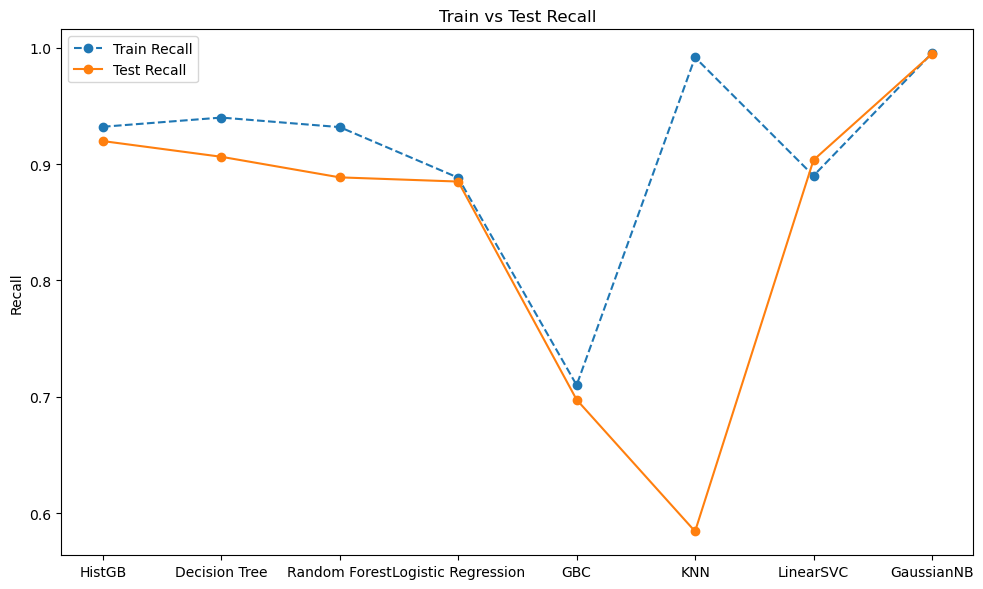

In [106]:
# 4. Train vs Test Recall (Overfitting Analysis)
plt.figure(figsize=(10, 6))
plt.plot(model_names, train_recall, marker='o', label='Train Recall', linestyle='--')
plt.plot(model_names, recall, marker='o', label='Test Recall')
plt.ylabel("Recall")
plt.title("Train vs Test Recall")
plt.legend()
plt.tight_layout()
plt.show()

In [82]:
# Compute gap % for each model
gap_percent = [(tr - te) / tr * 100 for tr, te in zip(train_recall, recall)]

# Print gap table
print("| Model              | Train Recall | Test Recall | Recall Gap (%) |")
print("|--------------------|--------------|-------------|----------------|")
for name, tr, te, gap in zip(model_names, train_recall, recall, gap_percent):
    print(f"| {name:<18} | {tr:.4f}       | {te:.4f}      | {gap:+6.2f}%       |")


| Model              | Train Recall | Test Recall | Recall Gap (%) |
|--------------------|--------------|-------------|----------------|
| HistGB             | 0.9321       | 0.9198      |  +1.32%       |
| Decision Tree      | 0.9400       | 0.9063      |  +3.59%       |
| Random Forest      | 0.9318       | 0.8886      |  +4.64%       |
| Logistic Regression | 0.8883       | 0.8850      |  +0.37%       |
| GBC                | 0.7100       | 0.6975      |  +1.76%       |
| KNN                | 0.9917       | 0.5843      | +41.08%       |
| LinearSVC          | 0.8900       | 0.9035      |  -1.52%       |
| GaussianNB         | 0.9953       | 0.9947      |  +0.06%       |


### Observations:
(Im using 10% difference in recall as a threshold to flag as overfit)
- HistGB, Decision Tree, Random Forest, Logistic Regression, GBC, LinearSVC, GaussianNB  have a **recall gap below 5%**, meaning **none are overfitting** by the defined threshold.
- **GaussianNB** has the **smallest gap** (+0.06%), showing excellent generalization.
- **RandomForest** and **Decision Tree** also show **minimal overfitting** and retain high recall.

|                     | **Predicted: 0**                                          | **Predicted: 1**                                                | **Total Actual** |
| ------------------- | --------------------------------------------------------- | --------------------------------------------------------------- | ---------------- |
| **Actual: 0**       | 🟩 **True Negatives (TN)**<br>Correctly predicted as negative | 🟥 **False Positives (FP)**<br>Incorrectly predicted as positive |                  |
| **Actual: 1**       | 🟥 **False Negatives (FN)**<br>Missed positive cases      | 🟩 **True Positives (TP)**<br>Correctly predicted positive cases 

- Most important value to look for is FN; bottom left 
- But its also important to check if the FP is too high; top right

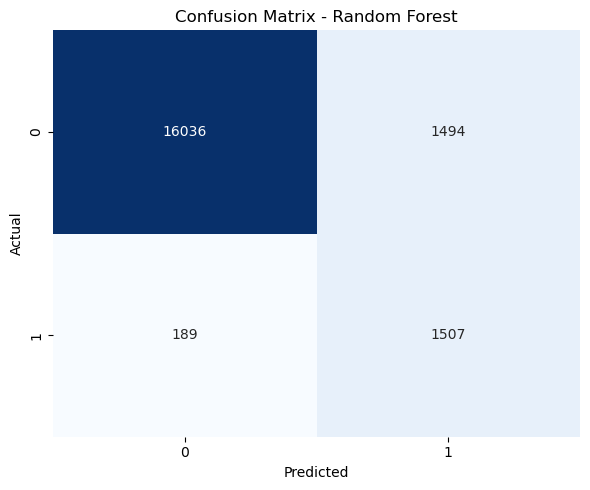

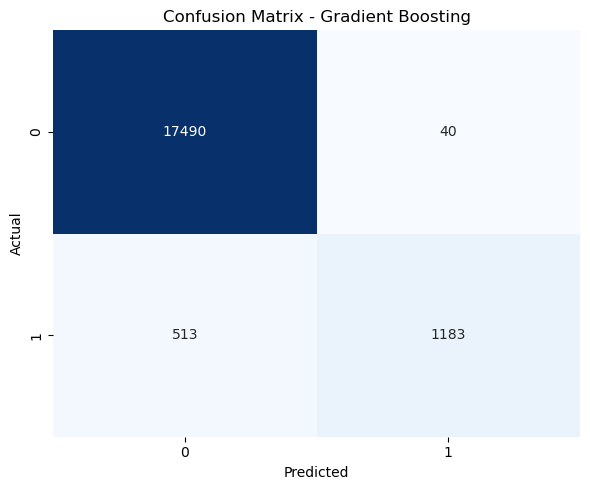

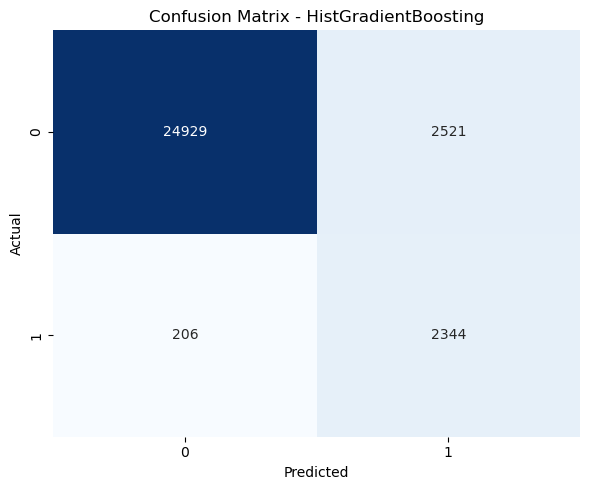

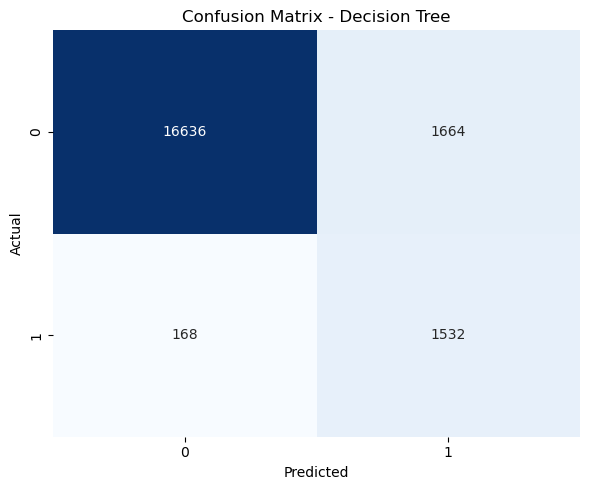

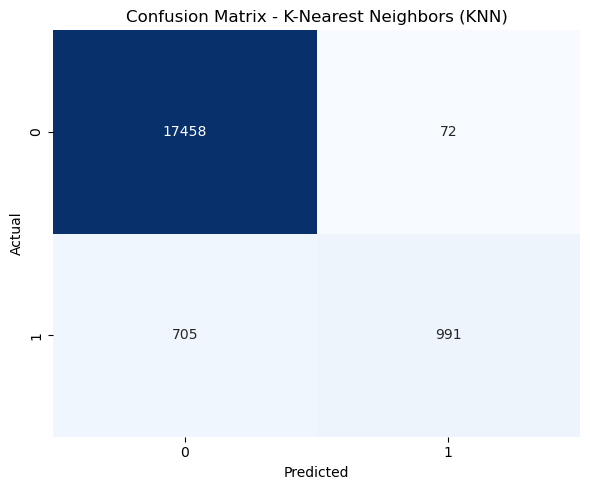

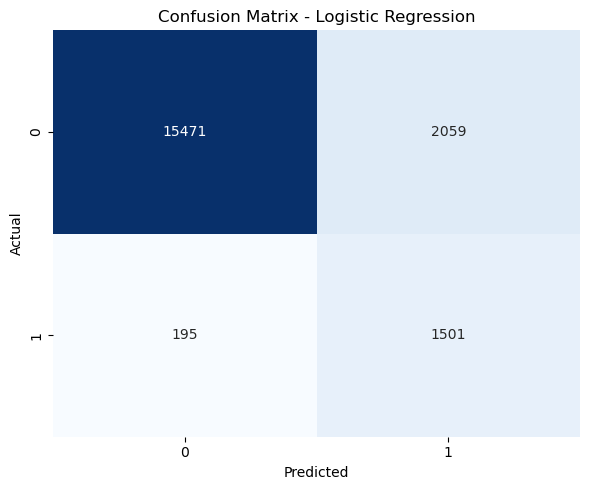

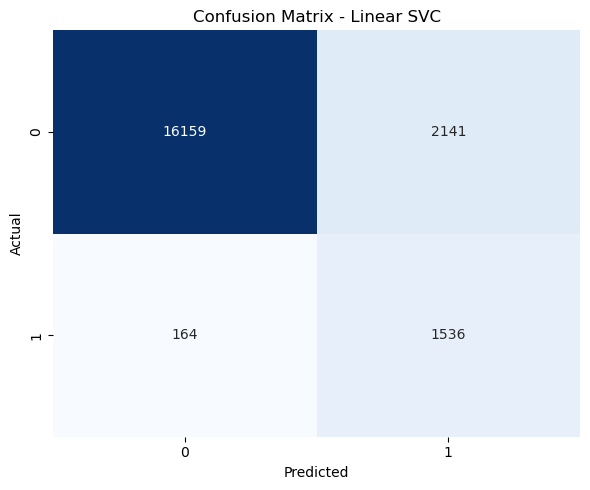

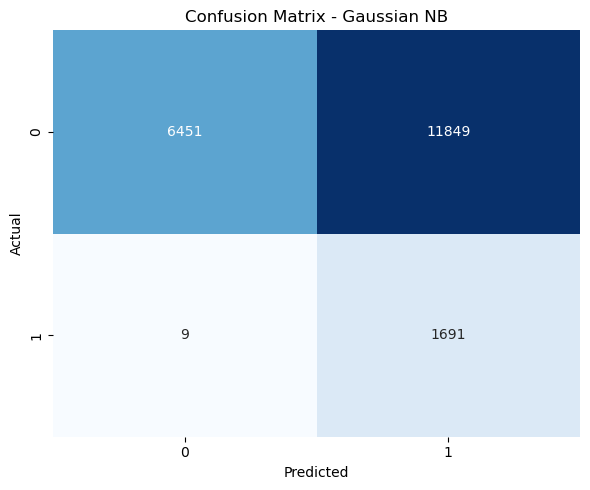

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Updated confusion matrices based on your latest reports
conf_matrices = {
    "Random Forest": np.array([[16036, 1494], [189, 1507]]),
    "Gradient Boosting": np.array([[17490, 40], [513, 1183]]),
    "HistGradientBoosting": np.array([[24929, 2521], [206, 2344]]),
    "Decision Tree": np.array([[16636, 1664], [168, 1532]]),
    "K-Nearest Neighbors (KNN)": np.array([[17458, 72], [705, 991]]),
    "Logistic Regression": np.array([[15471, 2059], [195, 1501]]),
    "Linear SVC": np.array([[16159, 2141], [164, 1536]]),
    "Gaussian NB": np.array([[6451, 11849], [9, 1691]])
}

# Function to plot all confusion matrices
def plot_all_confusion_matrices(conf_matrices):
    for model_name, cm in conf_matrices.items():
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

# Display all plots
plot_all_confusion_matrices(conf_matrices)


| Model                    | Recall (TP / [TP + FN]) | False Positives (FP) | Observation                                                                           |
|--------------------------|-------------------------|-----------------------|----------------------------------------------------------------------------------------|
| **HistGradientBoosting** | **0.9192**              | 2,521                 | **Best recall** — excellent at catching diabetics; higher FP is acceptable here       |
| **Decision Tree**        | 0.9012                  | 1,664                 | High recall and strong detection, FP is expected for imbalanced medical data          |
| **Random Forest**        | 0.8886                  | 1,494                 | Good balance — slightly lower recall, fewer FP than DT and HGB                        |
| **Linear SVC**           | 0.9035                  | 2,141                 | High recall — performs comparably to DT; FP is higher                                 |
| **Logistic Regression**  | 0.8850                  | 2,059                 | Competitive recall but higher FP — may over-flag, yet acceptable for screening        |
| **KNN**                  | 0.5843                  | 72                    | Very low recall — misses many diabetics, unsuitable despite extremely low FP          |
| **Gradient Boosting**    | 0.6975                  | **40**                | Excellent precision but very low recall — misses too many true cases                  |
| **Gaussian NB**          | **0.9947**              | 11,849                | Extremely high recall but **unacceptably high FP** — not usable in practical setting  |


- True positive means positives correctly predicted. (The test data has has 1696 positives in total)
- False positive means negatives wrongly predicted as positives.
- I need high true positive while making sure false positive is not too high

# Final Selection of Model

## Model Evaluation Summary
| Model                    | Recall | Precision | F1 Score | PR AUC | Overfit        |
|-------------------------|--------|-----------|----------|--------|----------------|
| **Gaussian NB**          | 0.9947 | 0.12      | 0.22     | 0.1247 | No             |
| **HistGradientBoosting** | 0.9192 | 0.48      | 0.63     | 0.4498 | No             |
| **Linear SVC**           | 0.9035 | 0.42      | 0.57     | 0.3856 | No             |
| **Decision Tree**        | 0.9012 | 0.48      | 0.63     | 0.4319 | Slight         |
| **Random Forest**        | 0.8886 | 0.50      | 0.64     | 0.4710 | Slight         |
| **Logistic Regression**  | 0.8850 | 0.42      | 0.57     | 0.3845 | No             |
| **Gradient Boosting**    | 0.6975 | 0.97      | 0.81     | 0.6999 | No             |
| **KNN**                  | 0.5843 | 0.93      | 0.72     | 0.5803 | Yes (memorizes) |

---

## Observations

### HistGradientBoostingClassifier

- Achieved the best trade-off between recall, precision, and PR AUC.
- Very stable generalization with minimal gap between train and test recall.
- Best suited for medical prediction tasks where recall is critical.
- PR AUC is solid, indicating good performance even on imbalanced data.

### GaussianNB

- Extremely high recall (99%) but very low precision (12%).
- Model strongly overpredicts positive class, resulting in many false positives.
- PR AUC is the lowest among all models, showing poor discrimination power.

### KNeighborsClassifier

- Precision is very high (93%), but recall is the lowest.
- Likely overfits the training data by memorizing patterns, which fails to generalize.
- Performance drops sharply on test recall compared to train recall.

### GradientBoostingClassifier

- Very high precision (97%) but recall is poor for this context.
- Optimizes log loss by default, which favors overall accuracy rather than minority class recall.
- Not ideal for imbalanced medical datasets where recall is more important.

### RandomForestClassifier

- Good balance of recall (0.89) and precision (0.50).
- Shows slight overfit based on the gap between train and test recall.
- Still one of the more robust models, but less stable than HistGradientBoosting.

### DecisionTreeClassifier

- Similar performance to Random Forest with slightly lower stability.
- Shows slight overfit due to its nature as a single unpruned tree.
- High interpretability is an advantage.

### LinearSVC

- Good recall (~0.90) but struggles with precision.
- Results in lower F1 and PR AUC.
- Suitable when linear separation is expected but not the best here.

### LogisticRegression

- Performs similarly to LinearSVC in terms of recall and precision.
- Low PR AUC suggests difficulty in ranking positive vs negative confidently.
- Still a reliable baseline model for comparison.

---

### Selected Model: HistGradientBoostingClassifier

Reasons for selection:

- Has the second highest recall
- Best balance between recall and precision
- Does not overfit so it is fitted well
- Strong F1 and PR AUC values


## Feature importance
- Hist gradient boosting does not support feature importance so im using SHAP test to determine feature importance

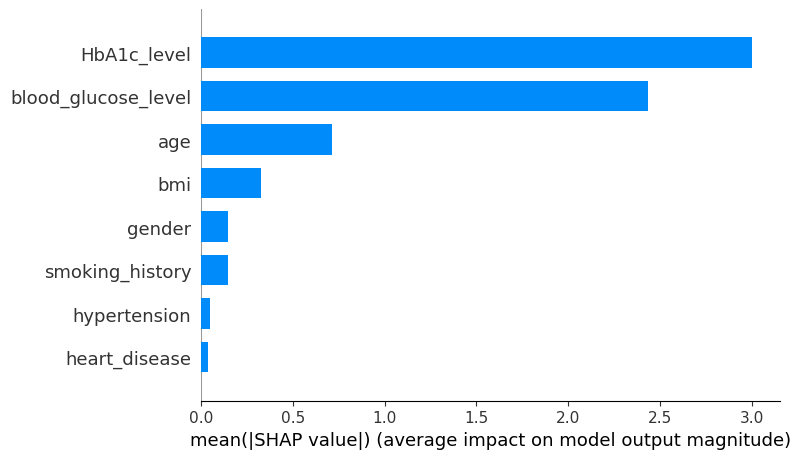

In [67]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Sample the test set
X_sample = X_LE_test.sample(n=1000, random_state=42)

# Step 2: SHAP explainer with additivity check off
explainer = shap.Explainer(hgb_model, X_sample)
shap_values = explainer(X_sample, check_additivity=False)

# Step 3: Bar chart (mean absolute SHAP values)
shap.summary_plot(shap_values, X_sample, plot_type="bar")


#### Observation on feature importance
- HBA1c and blood glucose have the most importance 
- heart disease and hypertension so im going to remove those 2 columns 

##### Plan to drop features 
1. drop heart disease and check metrics 
2. drop hypertension and check metrics 
3. drop heart disease and hypertension and check metrics

### Drop heart disease then train and test

In [95]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import optuna

# Make a copy and drop less important features
df_LE_reduced = df.copy().drop(columns=['heart_disease',])

# Separate features and target
X_LE_reduced = df_LE_reduced.drop('diabetes', axis=1)
y_LE_reduced = df_LE_reduced['diabetes']

# Train-test split
X_LE_reduced_train, X_LE_reduced_test, y_LE_reduced_train, y_LE_reduced_test = train_test_split(
    X_LE_reduced, y_LE_reduced, test_size=0.2, random_state=42, stratify=y_LE_reduced
)

# Label encoding (to prevent data leakage)
le_gender_reduced = LabelEncoder()
le_smoking_reduced = LabelEncoder()

X_LE_reduced_train['gender'] = le_gender_reduced.fit_transform(X_LE_reduced_train['gender'])
X_LE_reduced_train['smoking_history'] = le_smoking_reduced.fit_transform(X_LE_reduced_train['smoking_history'])

X_LE_reduced_test['gender'] = le_gender_reduced.transform(X_LE_reduced_test['gender'])
X_LE_reduced_test['smoking_history'] = le_smoking_reduced.transform(X_LE_reduced_test['smoking_history'])

# Optuna objective function
def objective_histgb_reduced(trial):
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)
    l2_regularization = trial.suggest_float('l2_regularization', 0, 10)
    
    clf = HistGradientBoostingClassifier(
        max_iter=max_iter,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        l2_regularization=l2_regularization,
        random_state=42
    )
    
    score = cross_val_score(clf, X_LE_reduced_train, y_LE_reduced_train, cv=3, scoring='average_precision', n_jobs=-1).mean()
    return score

# Run Optuna optimization
study_histgb_reduced = optuna.create_study(direction='maximize')
study_histgb_reduced.optimize(objective_histgb_reduced, callbacks=[early_stop_callback(50)])

# Output best result
print("Best average_precision:", study_histgb_reduced.best_trial.value)
print("Best Params:", study_histgb_reduced.best_trial.params)



from sklearn.metrics import recall_score, classification_report, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier

# Train best model using reduced features and best params from Optuna
hgb_model_reduced = HistGradientBoostingClassifier(
    **study_histgb_reduced.best_params,
    class_weight="balanced",
    random_state=42
)

# Fit the model
hgb_model_reduced.fit(X_LE_reduced_train, y_LE_reduced_train)

# Predict
y_reduced_pred = hgb_model_reduced.predict(X_LE_reduced_test)

# Evaluation
print("Final Test Recall:", recall_score(y_LE_reduced_test, y_reduced_pred))
print("---------------------------- classification report ----------------------------")
print(classification_report(y_LE_reduced_test, y_reduced_pred))
print("---------------------------- confusion matrix ----------------------------")
print(confusion_matrix(y_LE_reduced_test, y_reduced_pred))
print("---------------------------- Model fitting test ----------------------------")
print("Training data set recall:", recall_score(y_LE_reduced_train, hgb_model_reduced.predict(X_LE_reduced_train)))
print("Testing data set recall: ", recall_score(y_LE_reduced_test, y_reduced_pred))



[I 2025-07-31 06:11:27,206] A new study created in memory with name: no-name-b772f053-1efe-4e50-b7c5-ab4687c9edda
[I 2025-07-31 06:11:32,454] Trial 0 finished with value: 0.8846077708417689 and parameters: {'max_iter': 271, 'learning_rate': 0.0717814035119281, 'max_depth': 6, 'min_samples_leaf': 48, 'max_leaf_nodes': 89, 'l2_regularization': 8.12865213371611}. Best is trial 0 with value: 0.8846077708417689.
[I 2025-07-31 06:11:34,671] Trial 1 finished with value: 0.8845361603838598 and parameters: {'max_iter': 606, 'learning_rate': 0.2830630324854251, 'max_depth': 3, 'min_samples_leaf': 31, 'max_leaf_nodes': 36, 'l2_regularization': 1.250125146813016}. Best is trial 0 with value: 0.8846077708417689.
[I 2025-07-31 06:11:37,276] Trial 2 finished with value: 0.8847287982237667 and parameters: {'max_iter': 796, 'learning_rate': 0.22551693575051018, 'max_depth': 3, 'min_samples_leaf': 23, 'max_leaf_nodes': 22, 'l2_regularization': 6.296330960392517}. Best is trial 2 with value: 0.8847287982

Early stopping: No improvement in 50 trials.
Best average_precision: 0.8851190374356467
Best Params: {'max_iter': 665, 'learning_rate': 0.041938049373367384, 'max_depth': 3, 'min_samples_leaf': 18, 'max_leaf_nodes': 45, 'l2_regularization': 5.842063676862532}
Final Test Recall: 0.9241176470588235
---------------------------- classification report ----------------------------
              precision    recall  f1-score   support

           0       0.99      0.90      0.95     18300
           1       0.47      0.92      0.62      1700

    accuracy                           0.90     20000
   macro avg       0.73      0.91      0.78     20000
weighted avg       0.95      0.90      0.92     20000

---------------------------- confusion matrix ----------------------------
[[16510  1790]
 [  129  1571]]
---------------------------- Model fitting test ----------------------------
Training data set recall: 0.928235294117647
Testing data set recall:  0.9241176470588235


### Drop hypertension then train and test

In [96]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import optuna

# Make a copy and drop less important features
df_LE_reduced = df.copy().drop(columns=['hypertension'])

# Separate features and target
X_LE_reduced = df_LE_reduced.drop('diabetes', axis=1)
y_LE_reduced = df_LE_reduced['diabetes']

# Train-test split
X_LE_reduced_train, X_LE_reduced_test, y_LE_reduced_train, y_LE_reduced_test = train_test_split(
    X_LE_reduced, y_LE_reduced, test_size=0.2, random_state=42, stratify=y_LE_reduced
)

# Label encoding (to prevent data leakage)
le_gender_reduced = LabelEncoder()
le_smoking_reduced = LabelEncoder()

X_LE_reduced_train['gender'] = le_gender_reduced.fit_transform(X_LE_reduced_train['gender'])
X_LE_reduced_train['smoking_history'] = le_smoking_reduced.fit_transform(X_LE_reduced_train['smoking_history'])

X_LE_reduced_test['gender'] = le_gender_reduced.transform(X_LE_reduced_test['gender'])
X_LE_reduced_test['smoking_history'] = le_smoking_reduced.transform(X_LE_reduced_test['smoking_history'])

# Optuna objective function
def objective_histgb_reduced(trial):
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)
    l2_regularization = trial.suggest_float('l2_regularization', 0, 10)
    
    clf = HistGradientBoostingClassifier(
        max_iter=max_iter,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        l2_regularization=l2_regularization,
        random_state=42
    )
    
    score = cross_val_score(clf, X_LE_reduced_train, y_LE_reduced_train, cv=3, scoring='average_precision', n_jobs=-1).mean()
    return score

# Run Optuna optimization
study_histgb_reduced = optuna.create_study(direction='maximize')
study_histgb_reduced.optimize(objective_histgb_reduced, callbacks=[early_stop_callback(100)])

# Output best result
print("Best average_precision:", study_histgb_reduced.best_trial.value)
print("Best Params:", study_histgb_reduced.best_trial.params)



from sklearn.metrics import recall_score, classification_report, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier

# Train best model using reduced features and best params from Optuna
hgb_model_reduced = HistGradientBoostingClassifier(
    **study_histgb_reduced.best_params,
    class_weight="balanced",
    random_state=42
)

# Fit the model
hgb_model_reduced.fit(X_LE_reduced_train, y_LE_reduced_train)

# Predict
y_reduced_pred = hgb_model_reduced.predict(X_LE_reduced_test)

# Evaluation
print("Final Test Recall:", recall_score(y_LE_reduced_test, y_reduced_pred))
print("---------------------------- classification report ----------------------------")
print(classification_report(y_LE_reduced_test, y_reduced_pred))
print("---------------------------- confusion matrix ----------------------------")
print(confusion_matrix(y_LE_reduced_test, y_reduced_pred))
print("---------------------------- Model fitting test ----------------------------")
print("Training data set recall:", recall_score(y_LE_reduced_train, hgb_model_reduced.predict(X_LE_reduced_train)))
print("Testing data set recall: ", recall_score(y_LE_reduced_test, y_reduced_pred))



[I 2025-07-31 06:16:02,974] A new study created in memory with name: no-name-7e9118ad-8599-41f5-8d85-c62ee580aac0
[I 2025-07-31 06:16:04,034] Trial 0 finished with value: 0.8834329167506922 and parameters: {'max_iter': 944, 'learning_rate': 0.1595383486032044, 'max_depth': 7, 'min_samples_leaf': 11, 'max_leaf_nodes': 65, 'l2_regularization': 5.2155926460134605}. Best is trial 0 with value: 0.8834329167506922.
[I 2025-07-31 06:16:04,800] Trial 1 finished with value: 0.8814815370850407 and parameters: {'max_iter': 258, 'learning_rate': 0.29550676804636344, 'max_depth': 8, 'min_samples_leaf': 32, 'max_leaf_nodes': 92, 'l2_regularization': 1.8174228315640062}. Best is trial 0 with value: 0.8834329167506922.
[I 2025-07-31 06:16:05,802] Trial 2 finished with value: 0.8836533403761296 and parameters: {'max_iter': 702, 'learning_rate': 0.198844041039162, 'max_depth': 6, 'min_samples_leaf': 34, 'max_leaf_nodes': 42, 'l2_regularization': 2.756503360954523}. Best is trial 2 with value: 0.88365334

Early stopping: No improvement in 100 trials.
Best average_precision: 0.8853145208661751
Best Params: {'max_iter': 728, 'learning_rate': 0.13245887100519704, 'max_depth': 3, 'min_samples_leaf': 27, 'max_leaf_nodes': 75, 'l2_regularization': 8.714636999700035}
Final Test Recall: 0.9211764705882353
---------------------------- classification report ----------------------------
              precision    recall  f1-score   support

           0       0.99      0.90      0.95     18300
           1       0.47      0.92      0.62      1700

    accuracy                           0.91     20000
   macro avg       0.73      0.91      0.78     20000
weighted avg       0.95      0.91      0.92     20000

---------------------------- confusion matrix ----------------------------
[[16543  1757]
 [  134  1566]]
---------------------------- Model fitting test ----------------------------
Training data set recall: 0.925
Testing data set recall:  0.9211764705882353


### Drop heart disease and hypertension then train and test

In [97]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import optuna

# Make a copy and drop less important features
df_LE_reduced = df.copy().drop(columns=['hypertension', 'heart_disease'])

# Separate features and target
X_LE_reduced = df_LE_reduced.drop('diabetes', axis=1)
y_LE_reduced = df_LE_reduced['diabetes']

# Train-test split
X_LE_reduced_train, X_LE_reduced_test, y_LE_reduced_train, y_LE_reduced_test = train_test_split(
    X_LE_reduced, y_LE_reduced, test_size=0.2, random_state=42, stratify=y_LE_reduced
)

# Label encoding (to prevent data leakage)
le_gender_reduced = LabelEncoder()
le_smoking_reduced = LabelEncoder()

X_LE_reduced_train['gender'] = le_gender_reduced.fit_transform(X_LE_reduced_train['gender'])
X_LE_reduced_train['smoking_history'] = le_smoking_reduced.fit_transform(X_LE_reduced_train['smoking_history'])

X_LE_reduced_test['gender'] = le_gender_reduced.transform(X_LE_reduced_test['gender'])
X_LE_reduced_test['smoking_history'] = le_smoking_reduced.transform(X_LE_reduced_test['smoking_history'])

# Optuna objective function
def objective_histgb_reduced(trial):
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)
    l2_regularization = trial.suggest_float('l2_regularization', 0, 10)
    
    clf = HistGradientBoostingClassifier(
        max_iter=max_iter,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        l2_regularization=l2_regularization,
        random_state=42
    )
    
    score = cross_val_score(clf, X_LE_reduced_train, y_LE_reduced_train, cv=3, scoring='average_precision', n_jobs=-1).mean()
    return score

# Run Optuna optimization
study_histgb_reduced = optuna.create_study(direction='maximize')
study_histgb_reduced.optimize(objective_histgb_reduced, callbacks=[early_stop_callback(100)])

# Output best result
print("Best average_precision:", study_histgb_reduced.best_trial.value)
print("Best Params:", study_histgb_reduced.best_trial.params)



from sklearn.metrics import recall_score, classification_report, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier

# Train best model using reduced features and best params from Optuna
hgb_model_reduced = HistGradientBoostingClassifier(
    **study_histgb_reduced.best_params,
    class_weight="balanced",
    random_state=42
)

# Fit the model
hgb_model_reduced.fit(X_LE_reduced_train, y_LE_reduced_train)

# Predict
y_reduced_pred = hgb_model_reduced.predict(X_LE_reduced_test)

# Evaluation
print("Final Test Recall:", recall_score(y_LE_reduced_test, y_reduced_pred))
print("---------------------------- classification report ----------------------------")
print(classification_report(y_LE_reduced_test, y_reduced_pred))
print("---------------------------- confusion matrix ----------------------------")
print(confusion_matrix(y_LE_reduced_test, y_reduced_pred))
print("---------------------------- Model fitting test ----------------------------")
print("Training data set recall:", recall_score(y_LE_reduced_train, hgb_model_reduced.predict(X_LE_reduced_train)))
print("Testing data set recall: ", recall_score(y_LE_reduced_test, y_reduced_pred))


[I 2025-07-31 06:22:38,015] A new study created in memory with name: no-name-ffacf6a9-5556-4469-8427-55b3c9a709af
[I 2025-07-31 06:22:38,998] Trial 0 finished with value: 0.8787965150971702 and parameters: {'max_iter': 926, 'learning_rate': 0.1707618921284254, 'max_depth': 8, 'min_samples_leaf': 41, 'max_leaf_nodes': 54, 'l2_regularization': 0.06650505676353391}. Best is trial 0 with value: 0.8787965150971702.
[I 2025-07-31 06:22:39,866] Trial 1 finished with value: 0.8746696636283865 and parameters: {'max_iter': 120, 'learning_rate': 0.22414743024819705, 'max_depth': 11, 'min_samples_leaf': 16, 'max_leaf_nodes': 92, 'l2_regularization': 1.915737488364978}. Best is trial 0 with value: 0.8787965150971702.
[I 2025-07-31 06:22:40,711] Trial 2 finished with value: 0.8794755900140169 and parameters: {'max_iter': 188, 'learning_rate': 0.23741617693767234, 'max_depth': 9, 'min_samples_leaf': 36, 'max_leaf_nodes': 38, 'l2_regularization': 8.334602474364708}. Best is trial 2 with value: 0.87947

Early stopping: No improvement in 100 trials.
Best average_precision: 0.882437516486636
Best Params: {'max_iter': 895, 'learning_rate': 0.023656967518361022, 'max_depth': 3, 'min_samples_leaf': 45, 'max_leaf_nodes': 95, 'l2_regularization': 9.021950188072982}
Final Test Recall: 0.9229411764705883
---------------------------- classification report ----------------------------
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     18300
           1       0.45      0.92      0.61      1700

    accuracy                           0.90     20000
   macro avg       0.72      0.91      0.78     20000
weighted avg       0.95      0.90      0.91     20000

---------------------------- confusion matrix ----------------------------
[[16413  1887]
 [  131  1569]]
---------------------------- Model fitting test ----------------------------
Training data set recall: 0.9277941176470588
Testing data set recall:  0.9229411764705883


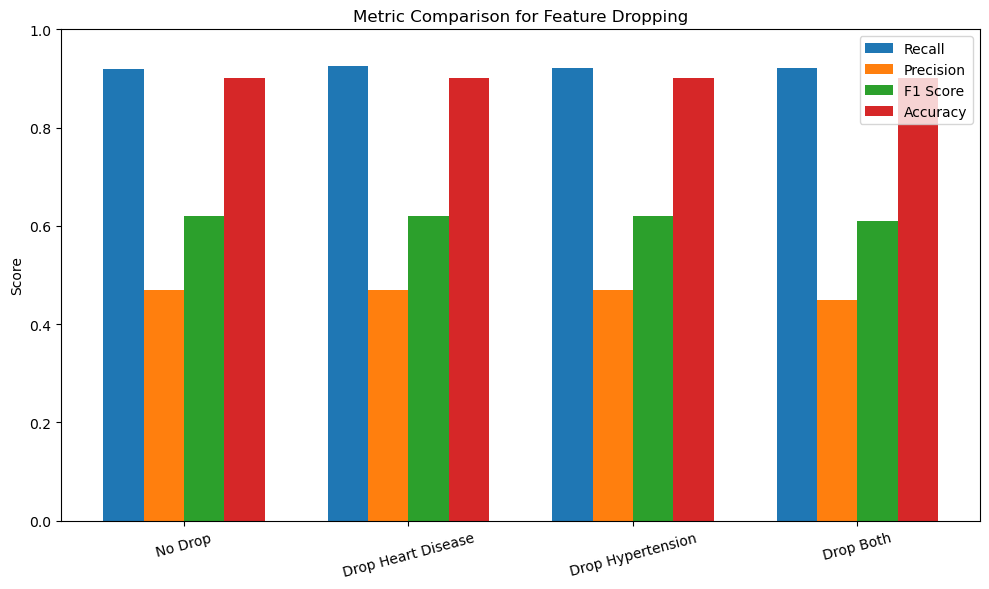

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your summary table
variants = [
    "No Drop",
    "Drop Heart Disease",
    "Drop Hypertension",
    "Drop Both"
]
recall = [0.9198, 0.9247, 0.9212, 0.9212]
precision = [0.47, 0.47, 0.47, 0.45]
f1 = [0.62, 0.62, 0.62, 0.61]
accuracy = [0.90, 0.90, 0.90, 0.90]

x = np.arange(len(variants))
bar_width = 0.18

plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*bar_width, recall, width=bar_width, label='Recall')
plt.bar(x - 0.5*bar_width, precision, width=bar_width, label='Precision')
plt.bar(x + 0.5*bar_width, f1, width=bar_width, label='F1 Score')
plt.bar(x + 1.5*bar_width, accuracy, width=bar_width, label='Accuracy')

plt.xticks(x, variants, rotation=15)
plt.ylabel("Score")
plt.title("Metric Comparison for Feature Dropping")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

### Comparison of models with different parameters dropped

| **Model Variant**           | **Test Recall** | **Precision** | **F1 Score** | **Accuracy** | **Train Recall** | **TP / FN**        |
| --------------------------- | --------------- | ------------- | ------------ | ------------ | ---------------- | ------------------ |
| **Original (All Features)** | 0.9198          | 0.47          | 0.62         | 0.90         | 0.9320           | TP: 1560 / FN: 136 |
| Drop Heart Disease          | **0.9247**      | 0.47          | 0.62         | 0.90         | 0.9284           | TP: 1572 / FN: 128 |
| Drop Hypertension           | 0.9212          | 0.47          | 0.62         | 0.90         | 0.9254           | TP: 1566 / FN: 134 |
| Drop Both                   | 0.9229          | 0.45          | 0.61         | 0.90         | 0.9254           | TP: 1569 / FN: 131 |


- All the feature drops cause very small difference in metrics; even if there is small increase in recall there is a considerable decrease in precision to discourage dropping. So im not going to drop any features

# Loading selected model

In [ ]:
joblib.dump(hgb_model, 'HGBCmodel.pkl')

['HGBCmodel.pkl']